# 5LSM0 Final Assignment: Cityscapes Challenge

For this final assignment, you're participating in the [Cityscapes Pixel-Level Segmentation Benchmark](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task)! You will do this in **groups of two students**. The goal is to create a network that performs semantic segmentation on the Cityscapes dataset. This dataset is a large collection of pictures taken from the perspective of a driver in various German cities. Each picture has a corresponding ground-truth image, where each pixel is given a color that corresponds to the class of the object appearing in that pixel. The table below shows the expected input and output of the solution you will be creating.

<table>
<thead>
    <tr><th>Input</th><th>Output</th></tr>
</thead>
<tbody>
    <tr>
        <td>
            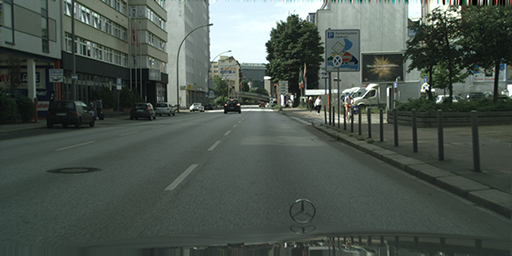
        </td>
        <td>
        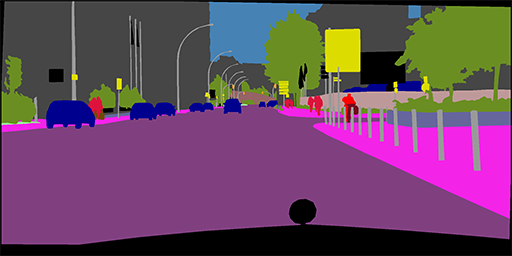
        </td>
    </tr>
    <tr>
        <td>Picture from the Cityscapes dataset.</td>
        <td>Semantic class assigned to each pixel. Every unique color corresponds to one class.</td>
    </tr>
</tbody>
</table>

Once you have a working solution, you can submit your output to the Cityscapes benchmark by creating an account and following [this link](https://www.cityscapes-dataset.com/submit/). We're excited to see where you will show up in the leaderboards!

Remember that this assignment determines 50% of your final grade. This amounts to **50 hours of active work** per student. Additionally, training your neural network will likely take many hours, take this into account when making your working schedule. This notebook downloads the required data for the benchmark and sets up a training pipeline so you can focus on creating networks using the skills you learned during this course. Some exercises have been included to get you started. Join us during computer class or message an assistant if you have any questions.

## Deliverables

Write a paper (one per group) in which you briefly introduce the problem, a baseline approach, your own addition(s), results and  conclusions. Use the **[IEEE double-column format](https://www.overleaf.com/latex/templates/ieee-conference-template/grfzhhncsfqn)** and **max. 4 pages**. You are allowed and expected to use ideas from literature and on the internet. Make sure you properly cite all the relevant sources in your paper. The assignment will be graded on paper quality, experimental setup, demonstrated insight and originality. What we at least expect is:

- Introduction to the problem: What are challenges? What are logical options to address them? What has been done for this or similar problems?
- Baseline implementation and results, using an off-the-shelf segmentation model.
- Improvements to that baseline, backed with experiments and results. Motivate your choices and explain your observations.
- Discussion on limitations and options to further improve.
- Clear and concise figures and tables to support your findings.

Submit your report and code to Canvas when you're finished.

## Requirements

You need at least Python version 3.7. The prefered library for creating your network is PyTorch. All third-party packages you need to run this notebook are imported below, such that you can install any missing dependencies before getting started.

In [1]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline

#Inserted this as their was an ssl verification error that was occuring while trying to download CIFAR 10
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


## Downloading and preprocessing the ground truth and input files
Let's start with downloading a ZIP-file that contains the training, testing and validation datasets.

In [2]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()
        
        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')
        
# Done!
print(f'All data downloaded')



Directory already downloaded: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\gtFine
Directory already downloaded: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\leftImg8bit
All data downloaded


The downloaded images are very large. A consumer-grade PC likely does not have enough GPU-memory or data bandwidth to create a viable implementation in the original size. For this reason, we run a pre-processing step on the dataset that downscales all images. Once you have a working model, you may consider using a larger `sample_size`.

In [3]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue
        
    print(f'Preprocessing: {dir_full}')
        
    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue
            
        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')
        
        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)
        
        for f in files:
            if not f.endswith('.png'):
                continue
            
            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)
            
print(f'Preprocessing done')


Preprocessed directory already exists: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\gtFine_256_128
Preprocessed directory already exists: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\leftImg8bit_256_128
Preprocessing done


## Data structures

Now that our data has been downloaded, we can proceed to define some data structures to model the structure of the provided data. Each semantic class that we aim to detect has a unique name, id and color. For more information on the datset, view [this link](https://www.cityscapes-dataset.com/dataset-overview/).

In [4]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str
    
    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))
    
    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))
            
    
# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str
    id: int
    color: Tuple[int, int, int]

# List of classes that we want to detect in the input
classes = [
    CityscapesClass('void', 0, (0, 0, 0)),
    CityscapesClass('dynamic', 1, (111, 74, 0)),
    CityscapesClass('ground', 2, (81, 0, 81)),
    CityscapesClass('road', 3, (128, 64, 128)),
    CityscapesClass('sidewalk', 4, (244, 35, 232)),
    CityscapesClass('parking', 5, (250, 170, 160)),
    CityscapesClass('rail track', 6, (230, 150, 140)),
    CityscapesClass('building', 7, (70, 70, 70)),
    CityscapesClass('wall', 8, (102, 102, 156)),
    CityscapesClass('fence', 9, (190, 153, 153)),
    CityscapesClass('guard rail', 10, (180, 165, 180)),
    CityscapesClass('bridge', 11, (150, 100, 100)),
    CityscapesClass('tunnel', 12, (150, 120, 90)),
    CityscapesClass('pole', 13, (153, 153, 153)),
    CityscapesClass('polegroup', 14, (153, 153, 153)),
    CityscapesClass('traffic light', 15, (250, 170, 30)),
    CityscapesClass('traffic sign', 16, (220, 220, 0)),
    CityscapesClass('vegetation', 17, (107, 142, 35)),
    CityscapesClass('terrain', 18, (152, 251, 152)),
    CityscapesClass('sky', 19, (70, 130, 180)),
    CityscapesClass('person', 20, (220, 20, 60)),
    CityscapesClass('rider', 21, (255, 0, 0)),
    CityscapesClass('car', 22, (0, 0, 142)),
    CityscapesClass('truck', 23, (0, 0, 70)),
    CityscapesClass('bus', 24, (0, 60, 100)),
    CityscapesClass('caravan', 25, (0, 0, 90)),
    CityscapesClass('trailer', 26, (0, 0, 110)),
    CityscapesClass('train', 27, (0, 80, 100)),
    CityscapesClass('motorcycle', 28, (0, 0, 230)),
    CityscapesClass('bicycle', 29, (119, 11, 32)),
]


## Dataset implementation

This section implements a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). It transforms image and target colorization pairs from the downloaded files into pairs of input and ground truth tensors. The ground truths are single-channel images where the value of each pixel is equal to the ID of the class represented by the color in the target. This will enable us to train the network using cross-entropy. 

In [5]:
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List

import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()
        
        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        
        pass
        
        ################################################################################# 
        
        # Convert the image to a tensor
        img = TF.to_tensor(img)
        
        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target += eq * i

        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(i)

            target[0] += eq * lbl.color[0]
            target[1] += eq * lbl.color[1]
            target[2] += eq * lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')
    
# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val", "test")
}

The Cityscapes dataset is split in three parts: `train`, `val` and `test`. If everything is set-up correctly, we should be able to draw a random sample from each split, convert it back to an image, and display it.

Subset,Amount,Size,Input sample,Truth sample
train,2975,256×128,,
val,500,256×128,,
test,1525,256×128,,

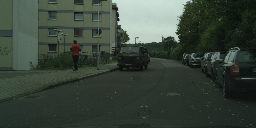
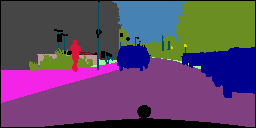
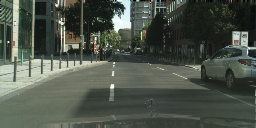
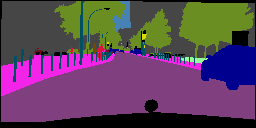
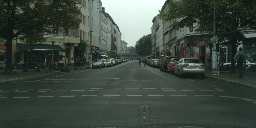
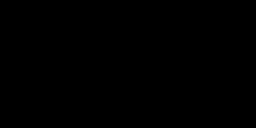

In [6]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split.items():    
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    
    input = TF.to_pil_image(input)
    truth = ds_sub.to_image(truth)
    
    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth: 
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


Notice that the `test` set has no ground truth labels, as this is the set used to score competitors' networks against each other. If you submit the best network that you have created to the Cityscapes competition, this is the set that is used to calculate your score.

## Calculating accuracy
Your score on the benchmark will be calculated according to the the intersection-over-union (IoU) metric. [This link](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task) describes how it is implemented in the testing suite. 

The function below is thus a measure for the accuracy of your solution. The `output` parameter represents the output of your network: a batch of multi-dimensional images with one channel per class. For every pixel, the class ID can be calculated by taking the index of the channel containing the maximum value. The `truths` parameter is a batch of ground truths from the `CityscapesDataset` defined above.

In [7]:
from sklearn.metrics import jaccard_score
def compute_iou(output: torch.Tensor, truths: torch.Tensor) -> float:
    # May want to re-think after understanding the output of U-net
    
    output = output.cpu().detach().numpy()
    truths = truths.cpu().detach().numpy()
  
    ## EXERCISE #####################################################################
    #
    # Implement the IoU metric that is used by the benchmark to grade your results.
    #     
    # `output` is a tensor of dimensions [Batch, Classes, Height, Width]
    # `truths` is a tensor of dimensions [Batch, Height, Width]
    #
    # Tip: Peform a sanity check that tests your implementation on a user-defined 
    #      tensor for which you know what the output should be.
    #
    ################################################################################# 
    
    
    # Getting the class id of each pixel
    classid_out = np.argmax(output, axis = 1) # Potential Error point as it may affect the config of image
    
    # Unraveling both the prediction and ground truth
    #classid_out = classid_out.ravel()
    #truths = truths.ravel()
    
    classid_out = classid_out.ravel()
    truths = truths.ravel()
    
    iou = jaccard_score(classid_out, truths, average='macro')

    #################################################################################
    
    return iou

In [19]:
# Draw a random sample
input, truth = random.choice(ds_split["val"])

iou = compute_iou(truth, truth)
print(iou)

1.0


## Training setup
The final step before you can implement your networks is to define the training process.

In [8]:
from torch import nn, optim
from torch.utils.data import DataLoader
    
class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset]):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        
        #self.device = "cpu"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Move the model onto the target device
        self.model = model.to(self.device)
        
        # Store the dataset split
        self.ds_split = ds_split
        
        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        #
        # See: https://pytorch.org/docs/stable/optim.html
        #
        ################################################################################# 
        
        self.optimizer = optim.Adam(model.parameters(), lr=0.1)
        
        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 
        
        self.critereon = nn.CrossEntropyLoss()
        
        ################################################################################# 
        
        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"
        
    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()
        
        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()
                
                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                
                print(inputs.shape)
                
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)
                
                # Run model on the inputs
                output = self.model(inputs)

                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.1)
                self.optimizer.step()
                
                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }
                
                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])
                
                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)

        sys.stdout.flush()
        
        # Return metrics
        return epoch_metrics
    
    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()
        
        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)
                
              

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
                total_accuracy += step_metrics["accuracy"]
        sys.stdout.flush()
        
        # Print mean of metrics
        total_loss /= amount
        total_accuracy /= amount
        print(f'Validation loss is {total_loss/amount}, validation accuracy is {total_accuracy}')
              
        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }
            
        
    def fit(self, epochs: int, batch_size:int):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        dl_train = DataLoader(ds_split["train"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(ds_split["val"], batch_size=batch_size, drop_last=True)
                
        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()
        
        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            print(f'Epoch {epoch}')
            metrics_train = self.train_epoch(dl_train)
            df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
            
            metrics_val = self.val_epoch(dl_val)            
            df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True) 
            
        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val


We can do a quick sanity check by creating a pass-through network that transforms the expected input shape into the output shape. While we don't expect this to solve the semantic segmentation problem, it does provide a way to test whether the inputs, truths and outputs are passed through the `Trainer` class correctly.

In [49]:
from torch import nn
import torch.nn.functional as F

# Define a module that transforms: RGB-channel image -> len(classes)-channel image
class Passthrough(nn.Module):
    def __init__(self, n_channels=3, n_classes=len(classes)):
        super().__init__()
        
        self.transform = nn.Conv2d(n_channels, n_classes, 1)
        
    def forward(self, x):
        x = F.softmax(self.transform(x), dim=1)
        return x
    
model = Passthrough()
    
# Train the passthrough network
print("Testing training process...")
trainer = Trainer(model, ds_split)
trainer.fit(epochs=1, batch_size=10)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

Testing training process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                        | 20/2975 [00:00<01:15, 38.91it/s, accuracy=0.00191, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                        | 30/2975 [00:00<01:16, 38.65it/s, accuracy=0.00681, loss=3.38]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                        | 40/2975 [00:01<01:17, 38.06it/s, accuracy=0.00675, loss=3.36]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                        | 50/2975 [00:01<01:17, 37.62it/s, accuracy=0.00996, loss=3.35]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                        | 60/2975 [00:01<01:18, 37.10it/s, accuracy=0.00647, loss=3.33]

torch.Size([10, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:01<01:20, 35.95it/s, accuracy=0.0141, loss=3.32]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:02<01:21, 35.60it/s, accuracy=0.0275, loss=3.3]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:02<01:21, 35.30it/s, accuracy=0.015, loss=3.29]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:02<01:21, 35.22it/s, accuracy=0.0128, loss=3.26]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:03<01:19, 36.21it/s, accuracy=0.0148, loss=3.25]

torch.Size([10, 3, 128, 256])


KeyboardInterrupt: 

If the section above ran without errors, then you are ready to continue.

## Define a baseline
You should start by implementing a network that performs semantic segmentation reasonably well (e.g. [U-Net](https://arxiv.org/pdf/1505.04597.pdf)). This will be the baseline against which you can compare your own improvements.

In [9]:
# Defining the U-Net Model as baseline

# Used the following sites as reference for the pytorch implementation 
# 1. https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
# 2. https://theaisummer.com/unet-architectures/

# Class to perform series of 3X3 convolutions
from torch import nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels = None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.doubleconv(x)

# Class to perform max pool followed by the Double conv

class Downconv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpoolconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpoolconv(x)

# Class to perform the upsampling plus the convolutions along with the concatenation

class Upconv(nn.Module):
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Building the U-net class
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        
        #Input Conv
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.inconv = DoubleConv(in_channels, 64)
        
        self.dconv1 = Downconv(64, 128)
        self.dconv2 = Downconv(128, 256)
        self.dconv3 = Downconv(256, 512)
        self.dconv4 = Downconv(512, 512)
        
        self.up1 = Upconv(1024, 256)
        self.up2 = Upconv(512, 128)
        self.up3 = Upconv(256, 64)
        self.up4 = Upconv(128, 64)
        
        self.outconv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        
        x1 = self.inconv(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x5 = self.dconv4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outconv(x)
        
        return x


In [10]:
# Function to check if model is built correctly
def test_UNet():
    x = torch.zeros((10, 3, 128, 256), dtype=torch.float32)
    num_classes = 10
    model = UNet(3, num_classes)
    out = model(x)
    print(out.size()) # Expect to see [10, 10, 128, 256]
test_UNet()

torch.Size([10, 10, 128, 256])


In [11]:
torch.cuda.empty_cache()

In [ ]:
#Training Baseline U-Net

num_classes = 30
model = UNet(3, num_classes)
    

print("Starting training process...")
trainer = Trainer(model, ds_split)
torch.cuda.empty_cache()
trainer.fit(epochs=10, batch_size=10)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

Starting training process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                        | 10/2975 [00:03<15:28,  3.19it/s, accuracy=0.00564, loss=3.47]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:03<08:16,  5.95it/s, accuracy=0.0286, loss=2.82]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:04<05:56,  8.27it/s, accuracy=0.0237, loss=3.15]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:05<04:50, 10.10it/s, accuracy=0.0472, loss=2.07]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                          | 50/2975 [00:05<04:16, 11.39it/s, accuracy=0.0528, loss=2.3]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:06<03:53, 12.48it/s, accuracy=0.0674, loss=1.76]

torch.Size([10, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:07<03:37, 13.37it/s, accuracy=0.0533, loss=1.9]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:07<03:27, 13.95it/s, accuracy=0.0518, loss=1.88]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:08<03:22, 14.26it/s, accuracy=0.0548, loss=1.85]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:09<03:17, 14.56it/s, accuracy=0.0512, loss=1.75]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:09<03:14, 14.75it/s, accuracy=0.0482, loss=1.8]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:10<03:11, 14.90it/s, accuracy=0.0604, loss=1.79]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:11<03:11, 14.88it/s, accuracy=0.046, loss=2.53]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:11<03:09, 14.93it/s, accuracy=0.0709, loss=1.43]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:12<03:07, 15.09it/s, accuracy=0.0911, loss=1.41]

torch.Size([10, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:12<03:05, 15.15it/s, accuracy=0.0905, loss=1.75]

torch.Size([10, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:13<03:06, 15.00it/s, accuracy=0.0916, loss=1.71]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:14<03:04, 15.15it/s, accuracy=0.0763, loss=1.52]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:14<03:03, 15.17it/s, accuracy=0.0862, loss=1.71]

torch.Size([10, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:15<03:06, 14.92it/s, accuracy=0.0933, loss=1.56]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:16<03:05, 14.89it/s, accuracy=0.0926, loss=1.63]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:17<03:05, 14.87it/s, accuracy=0.0877, loss=1.55]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:17<03:02, 15.05it/s, accuracy=0.0954, loss=1.42]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:18<03:04, 14.79it/s, accuracy=0.0892, loss=1.9]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:19<03:04, 14.75it/s, accuracy=0.0937, loss=1.43]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                       | 260/2975 [00:19<03:11, 14.21it/s, accuracy=0.108, loss=1.5]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:20<03:07, 14.43it/s, accuracy=0.107, loss=1.39]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:21<03:05, 14.52it/s, accuracy=0.0885, loss=1.51]

torch.Size([10, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [00:21<03:04, 14.55it/s, accuracy=0.126, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:22<03:04, 14.49it/s, accuracy=0.0859, loss=1.54]

torch.Size([10, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [00:23<03:01, 14.72it/s, accuracy=0.0726, loss=1.47]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [00:23<02:58, 14.85it/s, accuracy=0.112, loss=1.34]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [00:24<02:57, 14.89it/s, accuracy=0.106, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  11%|████▉                                      | 340/2975 [00:25<02:56, 14.97it/s, accuracy=0.103, loss=1.3]

torch.Size([10, 3, 128, 256])


Training:  12%|████▉                                     | 350/2975 [00:25<02:58, 14.72it/s, accuracy=0.133, loss=1.42]

torch.Size([10, 3, 128, 256])


Training:  12%|█████▏                                     | 360/2975 [00:26<03:00, 14.46it/s, accuracy=0.12, loss=1.18]

torch.Size([10, 3, 128, 256])


Training:  12%|█████▏                                    | 370/2975 [00:27<03:00, 14.43it/s, accuracy=0.105, loss=1.47]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                    | 380/2975 [00:27<02:57, 14.66it/s, accuracy=0.126, loss=1.32]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [00:28<02:53, 14.90it/s, accuracy=0.108, loss=1.45]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▋                                    | 400/2975 [00:29<02:51, 15.01it/s, accuracy=0.117, loss=1.27]

torch.Size([10, 3, 128, 256])


Training:  14%|██████                                      | 410/2975 [00:29<02:49, 15.17it/s, accuracy=0.1, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  14%|██████                                     | 420/2975 [00:30<02:48, 15.21it/s, accuracy=0.11, loss=1.24]

torch.Size([10, 3, 128, 256])


Training:  14%|██████                                    | 430/2975 [00:31<02:46, 15.27it/s, accuracy=0.122, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                   | 440/2975 [00:31<02:46, 15.27it/s, accuracy=0.109, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▎                                   | 450/2975 [00:32<02:44, 15.35it/s, accuracy=0.088, loss=1.23]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▍                                   | 460/2975 [00:33<02:43, 15.36it/s, accuracy=0.112, loss=1.36]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▋                                   | 470/2975 [00:33<02:50, 14.67it/s, accuracy=0.125, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                   | 480/2975 [00:34<02:50, 14.61it/s, accuracy=0.125, loss=1.23]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▉                                   | 490/2975 [00:35<02:51, 14.47it/s, accuracy=0.126, loss=1.19]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                   | 500/2975 [00:35<02:48, 14.66it/s, accuracy=0.126, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▏                                  | 510/2975 [00:36<02:49, 14.53it/s, accuracy=0.119, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▎                                  | 520/2975 [00:37<02:49, 14.50it/s, accuracy=0.156, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                  | 530/2975 [00:38<02:46, 14.68it/s, accuracy=0.123, loss=1.23]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▊                                   | 540/2975 [00:38<02:48, 14.43it/s, accuracy=0.139, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▉                                   | 550/2975 [00:39<02:47, 14.50it/s, accuracy=0.137, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  19%|████████                                   | 560/2975 [00:40<02:45, 14.59it/s, accuracy=0.15, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  19%|████████                                  | 570/2975 [00:40<02:49, 14.19it/s, accuracy=0.134, loss=1.37]

torch.Size([10, 3, 128, 256])


Training:  19%|████████▏                                 | 580/2975 [00:41<02:57, 13.52it/s, accuracy=0.146, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▎                                 | 590/2975 [00:42<03:00, 13.18it/s, accuracy=0.127, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▍                                 | 600/2975 [00:43<03:05, 12.80it/s, accuracy=0.133, loss=1.51]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                 | 610/2975 [00:44<03:07, 12.62it/s, accuracy=0.128, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▉                                  | 620/2975 [00:44<03:07, 12.57it/s, accuracy=0.139, loss=1.3]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [00:45<03:09, 12.40it/s, accuracy=0.131, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                 | 640/2975 [00:46<03:08, 12.40it/s, accuracy=0.137, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████▏                                | 650/2975 [00:47<03:04, 12.58it/s, accuracy=0.154, loss=1.11]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████▎                                | 660/2975 [00:48<02:57, 13.04it/s, accuracy=0.153, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [00:48<02:52, 13.35it/s, accuracy=0.143, loss=0.957]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▌                                | 680/2975 [00:49<02:50, 13.47it/s, accuracy=0.122, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▋                                | 690/2975 [00:50<02:44, 13.89it/s, accuracy=0.166, loss=1.18]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                                | 700/2975 [00:50<02:41, 14.13it/s, accuracy=0.165, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [00:51<02:38, 14.33it/s, accuracy=0.162, loss=0.999]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [00:52<02:35, 14.50it/s, accuracy=0.149, loss=0.963]

torch.Size([10, 3, 128, 256])


Training:  25%|███████████                                  | 730/2975 [00:52<02:33, 14.65it/s, accuracy=0.139, loss=1]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▍                               | 740/2975 [00:53<02:33, 14.59it/s, accuracy=0.161, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▌                               | 750/2975 [00:54<02:34, 14.42it/s, accuracy=0.134, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                               | 760/2975 [00:54<02:32, 14.52it/s, accuracy=0.135, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  26%|███████████▏                               | 770/2975 [00:55<02:30, 14.62it/s, accuracy=0.166, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  26%|███████████                               | 780/2975 [00:56<02:29, 14.67it/s, accuracy=0.155, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▏                              | 790/2975 [00:56<02:27, 14.78it/s, accuracy=0.148, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▎                              | 800/2975 [00:57<02:26, 14.81it/s, accuracy=0.143, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▍                              | 810/2975 [00:58<02:26, 14.82it/s, accuracy=0.161, loss=1.17]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [00:58<02:25, 14.83it/s, accuracy=0.169, loss=0.937]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▋                              | 830/2975 [00:59<02:24, 14.83it/s, accuracy=0.143, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▊                              | 840/2975 [01:00<02:23, 14.85it/s, accuracy=0.159, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████                              | 850/2975 [01:00<02:22, 14.87it/s, accuracy=0.154, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████▏                             | 860/2975 [01:01<02:22, 14.85it/s, accuracy=0.136, loss=1.26]

torch.Size([10, 3, 128, 256])


Training:  29%|█████████████▏                               | 870/2975 [01:02<02:21, 14.87it/s, accuracy=0.171, loss=1]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                             | 880/2975 [01:02<02:21, 14.85it/s, accuracy=0.148, loss=0.99]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▌                             | 890/2975 [01:03<02:20, 14.84it/s, accuracy=0.165, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  30%|█████████████                              | 900/2975 [01:04<02:19, 14.91it/s, accuracy=0.14, loss=1.29]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [01:04<02:18, 14.94it/s, accuracy=0.172, loss=0.863]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▉                             | 920/2975 [01:05<02:17, 14.94it/s, accuracy=0.172, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  31%|█████████████▏                            | 930/2975 [01:06<02:16, 14.95it/s, accuracy=0.168, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▎                            | 940/2975 [01:06<02:15, 14.98it/s, accuracy=0.167, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▍                            | 950/2975 [01:07<02:15, 14.99it/s, accuracy=0.133, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▌                            | 960/2975 [01:08<02:14, 14.94it/s, accuracy=0.152, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                            | 970/2975 [01:09<02:14, 14.94it/s, accuracy=0.163, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▊                            | 980/2975 [01:09<02:13, 14.91it/s, accuracy=0.18, loss=0.887]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▉                            | 990/2975 [01:10<02:13, 14.90it/s, accuracy=0.133, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  34%|██████████████                            | 1000/2975 [01:11<02:12, 14.88it/s, accuracy=0.16, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  34%|██████████████▎                           | 1010/2975 [01:11<02:12, 14.86it/s, accuracy=0.14, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [01:12<02:11, 14.89it/s, accuracy=0.152, loss=0.955]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▏                          | 1030/2975 [01:13<02:10, 14.94it/s, accuracy=0.129, loss=1.27]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▎                          | 1040/2975 [01:13<02:09, 14.97it/s, accuracy=0.143, loss=1.27]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▍                          | 1050/2975 [01:14<02:08, 14.95it/s, accuracy=0.141, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [01:15<02:08, 14.93it/s, accuracy=0.171, loss=0.895]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [01:15<02:07, 14.90it/s, accuracy=0.183, loss=0.946]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▉                          | 1080/2975 [01:16<02:07, 14.91it/s, accuracy=0.146, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████                          | 1090/2975 [01:17<02:06, 14.93it/s, accuracy=0.125, loss=1.33]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▏                         | 1100/2975 [01:17<02:05, 14.93it/s, accuracy=0.17, loss=0.937]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▎                         | 1110/2975 [01:18<02:05, 14.91it/s, accuracy=0.167, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▍                         | 1120/2975 [01:19<02:04, 14.91it/s, accuracy=0.144, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▌                         | 1130/2975 [01:19<02:04, 14.88it/s, accuracy=0.172, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [01:20<02:03, 14.91it/s, accuracy=0.174, loss=0.922]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [01:21<02:02, 14.90it/s, accuracy=0.158, loss=0.979]

torch.Size([10, 3, 128, 256])


Training:  39%|████████████████▍                         | 1160/2975 [01:21<02:01, 14.91it/s, accuracy=0.14, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  39%|█████████████████▎                          | 1170/2975 [01:22<02:00, 14.94it/s, accuracy=0.171, loss=1]

torch.Size([10, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [01:23<02:00, 14.91it/s, accuracy=0.175, loss=0.863]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▍                        | 1190/2975 [01:23<01:59, 14.94it/s, accuracy=0.171, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▌                        | 1200/2975 [01:24<01:58, 14.94it/s, accuracy=0.175, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [01:25<01:58, 14.95it/s, accuracy=0.169, loss=0.883]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▊                        | 1220/2975 [01:25<01:57, 14.96it/s, accuracy=0.141, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▉                        | 1230/2975 [01:26<01:56, 14.95it/s, accuracy=0.147, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [01:27<01:56, 14.90it/s, accuracy=0.172, loss=0.847]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [01:27<01:55, 14.89it/s, accuracy=0.186, loss=0.932]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▎                       | 1260/2975 [01:28<01:55, 14.87it/s, accuracy=0.151, loss=1.11]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [01:29<01:54, 14.89it/s, accuracy=0.159, loss=0.897]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [01:29<01:53, 14.88it/s, accuracy=0.188, loss=0.938]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▊                       | 1290/2975 [01:30<01:54, 14.76it/s, accuracy=0.151, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▉                       | 1300/2975 [01:31<01:53, 14.81it/s, accuracy=0.151, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  44%|██████████████████                       | 1310/2975 [01:31<01:51, 14.88it/s, accuracy=0.17, loss=0.931]

torch.Size([10, 3, 128, 256])


Training:  44%|██████████████████▏                      | 1320/2975 [01:32<01:51, 14.86it/s, accuracy=0.138, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▎                      | 1330/2975 [01:33<01:50, 14.84it/s, accuracy=0.152, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▍                      | 1340/2975 [01:33<01:50, 14.85it/s, accuracy=0.164, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  45%|███████████████████                       | 1350/2975 [01:34<01:49, 14.89it/s, accuracy=0.126, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [01:35<01:48, 14.94it/s, accuracy=0.169, loss=0.865]

torch.Size([10, 3, 128, 256])


Training:  46%|████████████████████▎                       | 1370/2975 [01:35<01:47, 14.93it/s, accuracy=0.169, loss=1]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [01:36<01:47, 14.86it/s, accuracy=0.164, loss=0.857]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [01:37<01:46, 14.87it/s, accuracy=0.189, loss=0.977]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [01:37<01:45, 14.86it/s, accuracy=0.201, loss=0.803]

torch.Size([10, 3, 128, 256])


Training:  47%|███████████████████▍                     | 1410/2975 [01:38<01:44, 14.92it/s, accuracy=0.183, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  48%|████████████████████                      | 1420/2975 [01:39<01:44, 14.92it/s, accuracy=0.18, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▋                     | 1430/2975 [01:39<01:44, 14.72it/s, accuracy=0.183, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [01:40<01:43, 14.80it/s, accuracy=0.159, loss=0.942]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▉                     | 1450/2975 [01:41<01:42, 14.88it/s, accuracy=0.174, loss=0.93]

torch.Size([10, 3, 128, 256])


Training:  49%|████████████████████                     | 1460/2975 [01:41<01:41, 14.86it/s, accuracy=0.149, loss=1.11]

torch.Size([10, 3, 128, 256])


Training:  49%|████████████████████▎                    | 1470/2975 [01:42<01:41, 14.79it/s, accuracy=0.156, loss=1.18]

torch.Size([10, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [01:43<01:40, 14.87it/s, accuracy=0.154, loss=0.982]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▌                    | 1490/2975 [01:43<01:39, 14.88it/s, accuracy=0.141, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▋                    | 1500/2975 [01:44<01:38, 14.91it/s, accuracy=0.164, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▊                    | 1510/2975 [01:45<01:38, 14.88it/s, accuracy=0.189, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [01:45<01:38, 14.84it/s, accuracy=0.179, loss=0.978]

torch.Size([10, 3, 128, 256])


Training:  51%|█████████████████████                    | 1530/2975 [01:46<01:37, 14.86it/s, accuracy=0.21, loss=0.816]

torch.Size([10, 3, 128, 256])


Training:  52%|█████████████████████▋                    | 1540/2975 [01:47<01:36, 14.87it/s, accuracy=0.2, loss=0.973]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [01:47<01:35, 14.86it/s, accuracy=0.186, loss=0.952]

torch.Size([10, 3, 128, 256])


Training:  52%|█████████████████████▍                   | 1560/2975 [01:48<01:35, 14.89it/s, accuracy=0.179, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [01:49<01:34, 14.92it/s, accuracy=0.193, loss=0.719]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [01:49<01:33, 14.98it/s, accuracy=0.221, loss=0.846]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [01:50<01:32, 14.94it/s, accuracy=0.167, loss=0.991]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [01:51<01:31, 14.95it/s, accuracy=0.207, loss=0.891]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████▋                   | 1610/2975 [01:51<01:31, 14.94it/s, accuracy=0.19, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1620/2975 [01:52<01:30, 14.96it/s, accuracy=0.172, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [01:53<01:29, 14.95it/s, accuracy=0.189, loss=0.923]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▌                  | 1640/2975 [01:53<01:29, 14.96it/s, accuracy=0.184, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▋                  | 1650/2975 [01:54<01:28, 14.94it/s, accuracy=0.164, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▉                  | 1660/2975 [01:55<01:28, 14.94it/s, accuracy=0.174, loss=0.97]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [01:55<01:27, 14.94it/s, accuracy=0.188, loss=0.859]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [01:56<01:27, 14.82it/s, accuracy=0.168, loss=0.896]

torch.Size([10, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1690/2975 [01:57<01:26, 14.87it/s, accuracy=0.174, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [01:58<01:25, 14.89it/s, accuracy=0.218, loss=0.729]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [01:58<01:25, 14.83it/s, accuracy=0.186, loss=0.872]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▋                 | 1720/2975 [01:59<01:24, 14.87it/s, accuracy=0.19, loss=0.953]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [02:00<01:23, 14.83it/s, accuracy=0.158, loss=0.954]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [02:00<01:23, 14.83it/s, accuracy=0.182, loss=0.971]

torch.Size([10, 3, 128, 256])


Training:  59%|████████████████████████                 | 1750/2975 [02:01<01:22, 14.83it/s, accuracy=0.172, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [02:02<01:21, 14.83it/s, accuracy=0.197, loss=0.861]

torch.Size([10, 3, 128, 256])


Training:  59%|████████████████████████▍                | 1770/2975 [02:02<01:21, 14.86it/s, accuracy=0.182, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [02:03<01:20, 14.88it/s, accuracy=0.202, loss=0.866]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [02:04<01:19, 14.86it/s, accuracy=0.209, loss=0.904]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [02:04<01:19, 14.84it/s, accuracy=0.201, loss=0.885]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [02:05<01:18, 14.89it/s, accuracy=0.195, loss=0.841]

torch.Size([10, 3, 128, 256])


Training:  61%|█████████████████████████                | 1820/2975 [02:06<01:17, 14.88it/s, accuracy=0.176, loss=1.11]

torch.Size([10, 3, 128, 256])


Training:  62%|█████████████████████████▏               | 1830/2975 [02:06<01:16, 14.90it/s, accuracy=0.22, loss=0.868]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [02:07<01:16, 14.92it/s, accuracy=0.178, loss=0.985]

torch.Size([10, 3, 128, 256])


Training:  62%|█████████████████████████▍               | 1850/2975 [02:08<01:15, 14.95it/s, accuracy=0.173, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1860/2975 [02:08<01:14, 14.97it/s, accuracy=0.185, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [02:09<01:14, 14.91it/s, accuracy=0.183, loss=0.858]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▉               | 1880/2975 [02:10<01:13, 14.81it/s, accuracy=0.179, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  64%|██████████████████████████               | 1890/2975 [02:10<01:13, 14.86it/s, accuracy=0.186, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  64%|██████████████████████████▏              | 1900/2975 [02:11<01:12, 14.85it/s, accuracy=0.25, loss=0.765]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [02:12<01:11, 14.89it/s, accuracy=0.186, loss=0.976]

torch.Size([10, 3, 128, 256])


Training:  65%|███████████████████████████               | 1920/2975 [02:12<01:10, 14.86it/s, accuracy=0.15, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [02:13<01:10, 14.91it/s, accuracy=0.179, loss=0.994]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████▋              | 1940/2975 [02:14<01:09, 14.94it/s, accuracy=0.192, loss=0.75]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [02:14<01:08, 14.95it/s, accuracy=0.164, loss=0.995]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [02:15<01:07, 14.93it/s, accuracy=0.165, loss=0.948]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [02:16<01:07, 14.92it/s, accuracy=0.175, loss=0.812]

torch.Size([10, 3, 128, 256])


Training:  67%|████████████████████████████▌              | 1980/2975 [02:16<01:06, 14.91it/s, accuracy=0.15, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  67%|███████████████████████████▍             | 1990/2975 [02:17<01:05, 14.94it/s, accuracy=0.156, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  67%|███████████████████████████▌             | 2000/2975 [02:18<01:05, 14.87it/s, accuracy=0.171, loss=0.95]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████             | 2010/2975 [02:18<01:04, 14.88it/s, accuracy=0.186, loss=0.879]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▊             | 2020/2975 [02:19<01:04, 14.90it/s, accuracy=0.18, loss=0.835]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2030/2975 [02:20<01:03, 14.89it/s, accuracy=0.19, loss=0.882]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [02:20<01:02, 14.86it/s, accuracy=0.199, loss=0.895]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▌            | 2050/2975 [02:21<01:02, 14.87it/s, accuracy=0.209, loss=0.981]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [02:22<01:01, 14.90it/s, accuracy=0.176, loss=0.848]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▊            | 2070/2975 [02:22<01:00, 14.92it/s, accuracy=0.194, loss=0.982]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████▋            | 2080/2975 [02:23<00:59, 14.93it/s, accuracy=0.173, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [02:24<00:59, 14.92it/s, accuracy=0.192, loss=0.721]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▉            | 2100/2975 [02:24<00:58, 14.94it/s, accuracy=0.189, loss=0.97]

torch.Size([10, 3, 128, 256])


Training:  71%|███████████████████████████████▏            | 2110/2975 [02:25<00:57, 14.97it/s, accuracy=0.184, loss=1]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [02:26<00:57, 14.95it/s, accuracy=0.191, loss=0.797]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [02:26<00:56, 14.94it/s, accuracy=0.184, loss=0.821]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [02:27<00:55, 14.92it/s, accuracy=0.215, loss=0.795]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [02:28<00:55, 14.94it/s, accuracy=0.173, loss=0.958]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [02:28<00:54, 14.96it/s, accuracy=0.188, loss=0.944]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [02:29<00:53, 14.91it/s, accuracy=0.202, loss=0.868]

torch.Size([10, 3, 128, 256])


Training:  73%|██████████████████████████████           | 2180/2975 [02:30<00:53, 14.88it/s, accuracy=0.173, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  74%|██████████████████████████████▉           | 2190/2975 [02:30<00:52, 14.89it/s, accuracy=0.213, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  74%|██████████████████████████████▎          | 2200/2975 [02:31<00:52, 14.88it/s, accuracy=0.183, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  74%|███████████████████████████████▏          | 2210/2975 [02:32<00:51, 14.88it/s, accuracy=0.17, loss=0.96]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [02:32<00:50, 14.84it/s, accuracy=0.195, loss=0.844]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [02:33<00:50, 14.78it/s, accuracy=0.203, loss=0.812]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████▊          | 2240/2975 [02:34<00:49, 14.82it/s, accuracy=0.186, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [02:34<00:48, 14.83it/s, accuracy=0.178, loss=0.906]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2260/2975 [02:35<00:48, 14.84it/s, accuracy=0.179, loss=0.979]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [02:36<00:47, 14.89it/s, accuracy=0.193, loss=0.767]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [02:36<00:46, 14.90it/s, accuracy=0.197, loss=0.773]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [02:37<00:46, 14.84it/s, accuracy=0.183, loss=0.856]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2300/2975 [02:38<00:45, 14.85it/s, accuracy=0.192, loss=0.928]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [02:38<00:44, 14.89it/s, accuracy=0.186, loss=0.972]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▉         | 2320/2975 [02:39<00:44, 14.88it/s, accuracy=0.187, loss=0.93]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [02:40<00:43, 14.92it/s, accuracy=0.204, loss=0.808]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [02:40<00:42, 14.92it/s, accuracy=0.169, loss=0.845]

torch.Size([10, 3, 128, 256])


Training:  79%|████████████████████████████████▍        | 2350/2975 [02:41<00:41, 14.89it/s, accuracy=0.157, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  79%|████████████████████████████████▌        | 2360/2975 [02:42<00:41, 14.76it/s, accuracy=0.189, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [02:43<00:40, 14.82it/s, accuracy=0.202, loss=0.889]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▊        | 2380/2975 [02:43<00:40, 14.84it/s, accuracy=0.171, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [02:44<00:39, 14.86it/s, accuracy=0.208, loss=0.875]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [02:45<00:38, 14.88it/s, accuracy=0.197, loss=0.792]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2410/2975 [02:45<00:38, 14.86it/s, accuracy=0.199, loss=0.925]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [02:46<00:37, 14.86it/s, accuracy=0.171, loss=0.939]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▍       | 2430/2975 [02:47<00:36, 14.86it/s, accuracy=0.162, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▋       | 2440/2975 [02:47<00:35, 14.88it/s, accuracy=0.165, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [02:48<00:35, 14.86it/s, accuracy=0.185, loss=0.954]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [02:49<00:34, 14.79it/s, accuracy=0.172, loss=0.884]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [02:49<00:34, 14.79it/s, accuracy=0.178, loss=0.981]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [02:50<00:33, 14.87it/s, accuracy=0.212, loss=0.701]

torch.Size([10, 3, 128, 256])


Training:  84%|██████████████████████████████████▎      | 2490/2975 [02:51<00:32, 14.87it/s, accuracy=0.156, loss=0.99]

torch.Size([10, 3, 128, 256])


Training:  84%|██████████████████████████████████▍      | 2500/2975 [02:51<00:32, 14.83it/s, accuracy=0.194, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [02:52<00:31, 14.91it/s, accuracy=0.209, loss=0.995]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▋      | 2520/2975 [02:53<00:30, 14.91it/s, accuracy=0.181, loss=0.89]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▊      | 2530/2975 [02:53<00:29, 14.86it/s, accuracy=0.208, loss=0.83]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [02:54<00:29, 14.90it/s, accuracy=0.195, loss=0.698]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [02:55<00:28, 14.91it/s, accuracy=0.185, loss=0.896]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [02:55<00:27, 14.90it/s, accuracy=0.201, loss=0.739]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [02:56<00:27, 14.91it/s, accuracy=0.211, loss=0.779]

torch.Size([10, 3, 128, 256])


Training:  87%|███████████████████████████████████▌     | 2580/2975 [02:57<00:26, 14.92it/s, accuracy=0.161, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [02:57<00:25, 14.94it/s, accuracy=0.209, loss=0.957]

torch.Size([10, 3, 128, 256])


Training:  87%|███████████████████████████████████▊     | 2600/2975 [02:58<00:25, 14.87it/s, accuracy=0.208, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2610/2975 [02:59<00:24, 14.88it/s, accuracy=0.194, loss=0.998]

torch.Size([10, 3, 128, 256])


Training:  88%|████████████████████████████████████     | 2620/2975 [02:59<00:23, 14.84it/s, accuracy=0.192, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [03:00<00:23, 14.84it/s, accuracy=0.209, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [03:01<00:22, 14.79it/s, accuracy=0.206, loss=0.758]

torch.Size([10, 3, 128, 256])


Training:  89%|█████████████████████████████████████▍    | 2650/2975 [03:01<00:21, 14.83it/s, accuracy=0.18, loss=1.17]

torch.Size([10, 3, 128, 256])


Training:  89%|████████████████████████████████████▋    | 2660/2975 [03:02<00:21, 14.88it/s, accuracy=0.202, loss=0.92]

torch.Size([10, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [03:03<00:20, 14.89it/s, accuracy=0.212, loss=0.779]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [03:03<00:19, 14.88it/s, accuracy=0.209, loss=0.766]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [03:04<00:19, 14.92it/s, accuracy=0.208, loss=0.707]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [03:05<00:18, 14.97it/s, accuracy=0.183, loss=0.882]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [03:05<00:17, 14.85it/s, accuracy=0.178, loss=0.934]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [03:06<00:17, 14.86it/s, accuracy=0.189, loss=0.858]

torch.Size([10, 3, 128, 256])


Training:  92%|█████████████████████████████████████▌   | 2730/2975 [03:07<00:16, 14.90it/s, accuracy=0.197, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2740/2975 [03:07<00:15, 14.91it/s, accuracy=0.191, loss=0.939]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [03:08<00:15, 14.93it/s, accuracy=0.223, loss=0.779]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [03:09<00:14, 14.93it/s, accuracy=0.183, loss=0.796]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [03:09<00:13, 14.96it/s, accuracy=0.174, loss=0.873]

torch.Size([10, 3, 128, 256])


Training:  93%|██████████████████████████████████████▎  | 2780/2975 [03:10<00:13, 14.91it/s, accuracy=0.187, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▍  | 2790/2975 [03:11<00:12, 14.89it/s, accuracy=0.181, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [03:11<00:11, 14.86it/s, accuracy=0.175, loss=0.874]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▊  | 2810/2975 [03:12<00:11, 14.79it/s, accuracy=0.177, loss=0.937]

torch.Size([10, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2820/2975 [03:13<00:10, 14.76it/s, accuracy=0.193, loss=0.881]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [03:13<00:09, 14.70it/s, accuracy=0.192, loss=0.842]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [03:14<00:09, 14.71it/s, accuracy=0.182, loss=0.949]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [03:15<00:08, 14.80it/s, accuracy=0.204, loss=0.739]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [03:15<00:07, 14.81it/s, accuracy=0.194, loss=0.789]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [03:16<00:07, 14.78it/s, accuracy=0.205, loss=0.778]

torch.Size([10, 3, 128, 256])


Training:  97%|███████████████████████████████████████▋ | 2880/2975 [03:17<00:06, 14.82it/s, accuracy=0.18, loss=0.981]

torch.Size([10, 3, 128, 256])


Training:  97%|███████████████████████████████████████▊ | 2890/2975 [03:18<00:05, 14.84it/s, accuracy=0.183, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [03:18<00:05, 14.84it/s, accuracy=0.192, loss=0.788]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [03:19<00:04, 14.84it/s, accuracy=0.199, loss=0.927]

torch.Size([10, 3, 128, 256])


Training:  98%|████████████████████████████████████████▏| 2920/2975 [03:20<00:03, 14.86it/s, accuracy=0.183, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  98%|████████████████████████████████████████▍| 2930/2975 [03:20<00:03, 14.85it/s, accuracy=0.19, loss=0.854]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [03:21<00:02, 14.86it/s, accuracy=0.199, loss=0.865]

torch.Size([10, 3, 128, 256])


Training:  99%|████████████████████████████████████████▋| 2950/2975 [03:22<00:01, 14.80it/s, accuracy=0.158, loss=1.17]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [03:22<00:01, 14.82it/s, accuracy=0.201, loss=0.785]

torch.Size([10, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [03:23<00:00, 14.78it/s, accuracy=0.207, loss=0.774]

torch.Size([5, 3, 128, 256])


Validation: 100%|█████████████████████████████████████████| 500/500 [00:18<00:00, 26.73it/s, accuracy=0.151, loss=1.21]

Validation loss is 0.027667772340774537, validation accuracy is 0.14244781478889026
Epoch 2



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:00<03:17, 15.03it/s, accuracy=0.193, loss=0.908]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:01<03:19, 14.81it/s, accuracy=0.199, loss=0.954]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:02<03:19, 14.76it/s, accuracy=0.217, loss=0.649]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:02<03:21, 14.59it/s, accuracy=0.194, loss=0.841]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:03<03:21, 14.55it/s, accuracy=0.191, loss=0.864]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:04<03:18, 14.66it/s, accuracy=0.206, loss=0.947]

torch.Size([10, 3, 128, 256])


Training:   2%|█                                           | 70/2975 [00:04<03:17, 14.70it/s, accuracy=0.2, loss=0.809]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:05<03:15, 14.80it/s, accuracy=0.184, loss=0.855]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                          | 90/2975 [00:06<03:14, 14.80it/s, accuracy=0.182, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:06<03:13, 14.87it/s, accuracy=0.206, loss=0.981]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:07<03:12, 14.88it/s, accuracy=0.184, loss=1.11]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                        | 120/2975 [00:08<03:11, 14.91it/s, accuracy=0.184, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:08<03:10, 14.92it/s, accuracy=0.21, loss=0.842]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:09<03:09, 14.94it/s, accuracy=0.188, loss=0.955]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:10<03:10, 14.87it/s, accuracy=0.198, loss=0.81]

torch.Size([10, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:10<03:09, 14.84it/s, accuracy=0.194, loss=0.912]

torch.Size([10, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:11<03:09, 14.84it/s, accuracy=0.206, loss=0.854]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:12<03:08, 14.82it/s, accuracy=0.158, loss=0.997]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:12<03:07, 14.88it/s, accuracy=0.198, loss=0.799]

torch.Size([10, 3, 128, 256])


Training:   7%|██▊                                       | 200/2975 [00:13<03:06, 14.88it/s, accuracy=0.19, loss=0.978]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:14<03:06, 14.84it/s, accuracy=0.165, loss=0.962]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:14<03:06, 14.80it/s, accuracy=0.186, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:15<03:05, 14.81it/s, accuracy=0.194, loss=0.822]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                       | 240/2975 [00:16<03:04, 14.82it/s, accuracy=0.2, loss=0.739]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:16<03:02, 14.90it/s, accuracy=0.205, loss=0.898]

torch.Size([10, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:17<03:02, 14.85it/s, accuracy=0.202, loss=0.814]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:18<03:01, 14.90it/s, accuracy=0.18, loss=0.771]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:18<03:00, 14.91it/s, accuracy=0.192, loss=0.778]

torch.Size([10, 3, 128, 256])


Training:  10%|███▉                                     | 290/2975 [00:19<03:00, 14.92it/s, accuracy=0.216, loss=0.735]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:20<03:00, 14.86it/s, accuracy=0.177, loss=0.976]

torch.Size([10, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [00:20<03:00, 14.76it/s, accuracy=0.199, loss=0.727]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [00:21<03:03, 14.48it/s, accuracy=0.168, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [00:22<03:01, 14.56it/s, accuracy=0.213, loss=0.85]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [00:23<03:02, 14.45it/s, accuracy=0.192, loss=0.778]

torch.Size([10, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [00:23<03:00, 14.53it/s, accuracy=0.192, loss=0.805]

torch.Size([10, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [00:24<02:59, 14.60it/s, accuracy=0.184, loss=0.858]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [00:25<02:56, 14.74it/s, accuracy=0.185, loss=0.809]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                    | 380/2975 [00:25<02:55, 14.76it/s, accuracy=0.188, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [00:26<02:55, 14.77it/s, accuracy=0.17, loss=0.857]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▊                                     | 400/2975 [00:27<02:54, 14.79it/s, accuracy=0.188, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [00:27<02:53, 14.82it/s, accuracy=0.202, loss=0.766]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [00:28<02:52, 14.79it/s, accuracy=0.235, loss=0.737]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▉                                   | 430/2975 [00:29<02:52, 14.79it/s, accuracy=0.225, loss=0.821]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                   | 440/2975 [00:29<02:51, 14.80it/s, accuracy=0.163, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [00:30<02:50, 14.81it/s, accuracy=0.219, loss=0.736]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▍                                   | 460/2975 [00:31<02:49, 14.85it/s, accuracy=0.21, loss=0.796]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [00:31<02:48, 14.84it/s, accuracy=0.177, loss=0.875]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [00:32<02:47, 14.89it/s, accuracy=0.223, loss=0.796]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [00:33<02:47, 14.87it/s, accuracy=0.234, loss=0.788]

torch.Size([10, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [00:33<02:46, 14.85it/s, accuracy=0.205, loss=0.758]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [00:34<02:46, 14.84it/s, accuracy=0.229, loss=0.799]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [00:35<02:45, 14.86it/s, accuracy=0.198, loss=0.893]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [00:35<02:44, 14.91it/s, accuracy=0.212, loss=0.784]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [00:36<02:43, 14.89it/s, accuracy=0.223, loss=0.726]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▊                                  | 550/2975 [00:37<02:43, 14.87it/s, accuracy=0.206, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [00:37<02:42, 14.85it/s, accuracy=0.236, loss=0.575]

torch.Size([10, 3, 128, 256])


Training:  19%|████████                                  | 570/2975 [00:38<02:41, 14.86it/s, accuracy=0.181, loss=0.84]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [00:39<02:41, 14.86it/s, accuracy=0.207, loss=0.868]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [00:39<02:39, 14.93it/s, accuracy=0.202, loss=0.904]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▍                                 | 600/2975 [00:40<02:38, 14.95it/s, accuracy=0.193, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [00:41<02:38, 14.89it/s, accuracy=0.189, loss=0.907]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [00:41<02:37, 14.91it/s, accuracy=0.195, loss=0.996]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [00:42<02:37, 14.89it/s, accuracy=0.188, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [00:43<02:39, 14.63it/s, accuracy=0.222, loss=0.738]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▉                                | 650/2975 [00:43<02:39, 14.58it/s, accuracy=0.179, loss=0.941]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████▎                                | 660/2975 [00:44<02:39, 14.51it/s, accuracy=0.189, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▍                                | 670/2975 [00:45<02:38, 14.56it/s, accuracy=0.217, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [00:45<02:37, 14.54it/s, accuracy=0.213, loss=0.982]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [00:46<02:36, 14.62it/s, accuracy=0.193, loss=0.852]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [00:47<02:34, 14.74it/s, accuracy=0.226, loss=0.929]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [00:48<02:33, 14.77it/s, accuracy=0.204, loss=0.849]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [00:48<02:32, 14.80it/s, accuracy=0.174, loss=0.998]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████                               | 730/2975 [00:49<02:31, 14.83it/s, accuracy=0.213, loss=0.796]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [00:50<02:30, 14.86it/s, accuracy=0.226, loss=0.921]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [00:50<02:30, 14.83it/s, accuracy=0.184, loss=0.999]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▍                              | 760/2975 [00:51<02:29, 14.85it/s, accuracy=0.216, loss=0.865]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [00:52<02:28, 14.90it/s, accuracy=0.194, loss=0.885]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                              | 780/2975 [00:52<02:27, 14.86it/s, accuracy=0.197, loss=0.841]

torch.Size([10, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [00:53<02:27, 14.86it/s, accuracy=0.217, loss=0.953]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▎                              | 800/2975 [00:54<02:26, 14.86it/s, accuracy=0.23, loss=0.742]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▏                             | 810/2975 [00:54<02:25, 14.87it/s, accuracy=0.194, loss=0.893]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [00:55<02:24, 14.89it/s, accuracy=0.204, loss=0.837]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [00:56<02:24, 14.88it/s, accuracy=0.201, loss=0.892]

torch.Size([10, 3, 128, 256])


Training:  28%|████████████▏                              | 840/2975 [00:56<02:23, 14.88it/s, accuracy=0.19, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████                              | 850/2975 [00:57<02:22, 14.94it/s, accuracy=0.167, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▊                             | 860/2975 [00:58<02:22, 14.89it/s, accuracy=0.199, loss=0.808]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████▎                             | 870/2975 [00:58<02:21, 14.91it/s, accuracy=0.174, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                             | 880/2975 [00:59<02:20, 14.89it/s, accuracy=0.187, loss=0.85]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [01:00<02:19, 14.94it/s, accuracy=0.195, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [01:00<02:18, 14.96it/s, accuracy=0.199, loss=0.839]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [01:01<02:17, 14.97it/s, accuracy=0.206, loss=0.786]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [01:02<02:16, 15.01it/s, accuracy=0.226, loss=0.727]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [01:02<02:17, 14.90it/s, accuracy=0.197, loss=0.911]

torch.Size([10, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [01:03<02:16, 14.86it/s, accuracy=0.251, loss=0.703]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [01:04<02:16, 14.84it/s, accuracy=0.213, loss=0.718]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▏                           | 960/2975 [01:04<02:15, 14.88it/s, accuracy=0.207, loss=0.708]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [01:05<02:14, 14.90it/s, accuracy=0.197, loss=0.926]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [01:06<02:14, 14.86it/s, accuracy=0.213, loss=0.859]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [01:06<02:13, 14.83it/s, accuracy=0.222, loss=0.723]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▊                           | 1000/2975 [01:07<02:13, 14.79it/s, accuracy=0.21, loss=0.782]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▌                          | 1010/2975 [01:08<02:12, 14.79it/s, accuracy=0.225, loss=0.862]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [01:08<02:12, 14.80it/s, accuracy=0.253, loss=0.679]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [01:09<02:11, 14.84it/s, accuracy=0.179, loss=0.921]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [01:10<02:10, 14.83it/s, accuracy=0.213, loss=0.741]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [01:10<02:09, 14.83it/s, accuracy=0.205, loss=0.791]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [01:11<02:09, 14.82it/s, accuracy=0.231, loss=0.739]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▋                          | 1070/2975 [01:12<02:08, 14.77it/s, accuracy=0.205, loss=0.82]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [01:12<02:08, 14.75it/s, accuracy=0.213, loss=0.969]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▍                          | 1090/2975 [01:13<02:08, 14.62it/s, accuracy=0.19, loss=0.78]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [01:14<02:08, 14.61it/s, accuracy=0.221, loss=0.783]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▋                          | 1110/2975 [01:14<02:06, 14.71it/s, accuracy=0.2, loss=0.782]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [01:15<02:06, 14.71it/s, accuracy=0.248, loss=0.693]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [01:16<02:05, 14.70it/s, accuracy=0.226, loss=0.738]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [01:16<02:04, 14.72it/s, accuracy=0.205, loss=0.749]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [01:17<02:03, 14.77it/s, accuracy=0.194, loss=0.963]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [01:18<02:02, 14.79it/s, accuracy=0.201, loss=0.949]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [01:19<02:01, 14.81it/s, accuracy=0.188, loss=0.776]

torch.Size([10, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [01:19<02:00, 14.88it/s, accuracy=0.237, loss=0.738]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [01:20<01:59, 14.91it/s, accuracy=0.215, loss=0.989]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [01:21<01:58, 14.94it/s, accuracy=0.218, loss=0.775]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [01:21<01:58, 14.95it/s, accuracy=0.163, loss=0.842]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▍                       | 1220/2975 [01:22<01:57, 14.89it/s, accuracy=0.211, loss=0.793]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [01:23<01:57, 14.88it/s, accuracy=0.219, loss=0.846]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [01:23<01:56, 14.94it/s, accuracy=0.224, loss=0.898]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [01:24<01:55, 14.95it/s, accuracy=0.196, loss=0.844]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▎                       | 1260/2975 [01:25<01:54, 14.94it/s, accuracy=0.228, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [01:25<01:54, 14.87it/s, accuracy=0.208, loss=0.778]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [01:26<01:53, 14.88it/s, accuracy=0.189, loss=0.974]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▊                       | 1290/2975 [01:27<01:53, 14.85it/s, accuracy=0.195, loss=0.78]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [01:27<01:53, 14.77it/s, accuracy=0.205, loss=0.743]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [01:28<01:52, 14.76it/s, accuracy=0.218, loss=0.839]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [01:29<01:52, 14.77it/s, accuracy=0.224, loss=0.781]

torch.Size([10, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [01:29<01:51, 14.82it/s, accuracy=0.207, loss=0.896]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [01:30<01:50, 14.75it/s, accuracy=0.221, loss=0.758]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [01:31<01:50, 14.76it/s, accuracy=0.198, loss=0.898]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1360/2975 [01:31<01:49, 14.77it/s, accuracy=0.193, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [01:32<01:48, 14.78it/s, accuracy=0.198, loss=0.835]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [01:33<01:47, 14.78it/s, accuracy=0.224, loss=0.779]

torch.Size([10, 3, 128, 256])


Training:  47%|████████████████████▌                       | 1390/2975 [01:33<01:47, 14.81it/s, accuracy=0.172, loss=1]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [01:34<01:45, 14.89it/s, accuracy=0.216, loss=0.925]

torch.Size([10, 3, 128, 256])


Training:  47%|███████████████████▉                      | 1410/2975 [01:35<01:45, 14.90it/s, accuracy=0.227, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████                     | 1420/2975 [01:35<01:44, 14.88it/s, accuracy=0.185, loss=0.875]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [01:36<01:43, 14.92it/s, accuracy=0.182, loss=0.804]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [01:37<01:43, 14.90it/s, accuracy=0.166, loss=0.794]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [01:37<01:42, 14.92it/s, accuracy=0.203, loss=0.817]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [01:38<01:41, 14.95it/s, accuracy=0.192, loss=0.816]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [01:39<01:40, 14.92it/s, accuracy=0.219, loss=0.756]

torch.Size([10, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [01:39<01:40, 14.91it/s, accuracy=0.226, loss=0.766]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [01:40<01:39, 14.86it/s, accuracy=0.202, loss=0.799]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [01:41<01:39, 14.88it/s, accuracy=0.218, loss=0.776]

torch.Size([10, 3, 128, 256])


Training:  51%|█████████████████████▎                    | 1510/2975 [01:41<01:38, 14.89it/s, accuracy=0.17, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [01:42<01:37, 14.90it/s, accuracy=0.211, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  51%|█████████████████████                    | 1530/2975 [01:43<01:36, 14.90it/s, accuracy=0.191, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  52%|█████████████████████▏                   | 1540/2975 [01:43<01:36, 14.93it/s, accuracy=0.22, loss=0.686]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [01:44<01:35, 14.91it/s, accuracy=0.221, loss=0.754]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [01:45<01:34, 14.92it/s, accuracy=0.219, loss=0.811]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▋                   | 1570/2975 [01:45<01:33, 14.96it/s, accuracy=0.19, loss=0.819]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [01:46<01:33, 14.93it/s, accuracy=0.189, loss=0.867]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [01:47<01:33, 14.88it/s, accuracy=0.236, loss=0.645]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [01:47<01:32, 14.84it/s, accuracy=0.234, loss=0.689]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [01:48<01:32, 14.83it/s, accuracy=0.184, loss=0.948]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [01:49<01:32, 14.68it/s, accuracy=0.235, loss=0.636]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▍                  | 1630/2975 [01:49<01:31, 14.76it/s, accuracy=0.245, loss=0.68]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████                  | 1640/2975 [01:50<01:30, 14.79it/s, accuracy=0.224, loss=0.615]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▋                  | 1650/2975 [01:51<01:29, 14.86it/s, accuracy=0.217, loss=0.68]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [01:51<01:29, 14.76it/s, accuracy=0.231, loss=0.749]

torch.Size([10, 3, 128, 256])


Training:  56%|███████████████████████                  | 1670/2975 [01:52<01:28, 14.77it/s, accuracy=0.176, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [01:53<01:27, 14.77it/s, accuracy=0.225, loss=0.746]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1690/2975 [01:54<01:26, 14.82it/s, accuracy=0.216, loss=0.834]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [01:54<01:26, 14.82it/s, accuracy=0.245, loss=0.634]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [01:55<01:25, 14.86it/s, accuracy=0.207, loss=0.766]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [01:56<01:24, 14.80it/s, accuracy=0.218, loss=0.773]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [01:56<01:23, 14.85it/s, accuracy=0.185, loss=0.852]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [01:57<01:22, 14.92it/s, accuracy=0.265, loss=0.663]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [01:58<01:22, 14.90it/s, accuracy=0.222, loss=0.879]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [01:58<01:21, 14.87it/s, accuracy=0.208, loss=0.679]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▊                | 1770/2975 [01:59<01:20, 14.91it/s, accuracy=0.219, loss=0.865]

torch.Size([10, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [02:00<01:20, 14.93it/s, accuracy=0.186, loss=0.969]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████▋                | 1790/2975 [02:00<01:19, 14.88it/s, accuracy=0.205, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [02:01<01:18, 14.90it/s, accuracy=0.226, loss=0.725]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [02:02<01:18, 14.87it/s, accuracy=0.193, loss=0.721]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [02:02<01:17, 14.92it/s, accuracy=0.227, loss=0.617]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [02:03<01:17, 14.85it/s, accuracy=0.247, loss=0.661]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [02:04<01:16, 14.81it/s, accuracy=0.171, loss=0.871]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [02:04<01:15, 14.87it/s, accuracy=0.184, loss=0.952]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████               | 1860/2975 [02:05<01:15, 14.85it/s, accuracy=0.218, loss=0.744]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [02:06<01:14, 14.84it/s, accuracy=0.254, loss=0.581]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▉               | 1880/2975 [02:06<01:13, 14.88it/s, accuracy=0.182, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  64%|██████████████████████████               | 1890/2975 [02:07<01:12, 14.88it/s, accuracy=0.216, loss=0.75]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [02:08<01:12, 14.88it/s, accuracy=0.197, loss=0.914]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [02:08<01:11, 14.88it/s, accuracy=0.187, loss=0.931]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [02:09<01:10, 14.91it/s, accuracy=0.235, loss=0.706]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [02:10<01:10, 14.87it/s, accuracy=0.208, loss=0.842]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [02:10<01:09, 14.90it/s, accuracy=0.263, loss=0.792]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [02:11<01:08, 14.88it/s, accuracy=0.221, loss=0.841]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [02:12<01:08, 14.85it/s, accuracy=0.232, loss=0.609]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [02:12<01:07, 14.85it/s, accuracy=0.224, loss=0.765]

torch.Size([10, 3, 128, 256])


Training:  67%|███████████████████████████▉              | 1980/2975 [02:13<01:07, 14.83it/s, accuracy=0.21, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [02:14<01:06, 14.82it/s, accuracy=0.201, loss=0.722]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [02:14<01:05, 14.89it/s, accuracy=0.235, loss=0.674]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████             | 2010/2975 [02:15<01:04, 14.92it/s, accuracy=0.215, loss=0.844]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [02:16<01:04, 14.88it/s, accuracy=0.216, loss=0.836]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2030/2975 [02:16<01:03, 14.83it/s, accuracy=0.247, loss=0.695]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [02:17<01:02, 14.88it/s, accuracy=0.209, loss=0.788]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▌            | 2050/2975 [02:18<01:02, 14.87it/s, accuracy=0.218, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [02:18<01:01, 14.87it/s, accuracy=0.205, loss=0.948]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████▌            | 2070/2975 [02:19<01:00, 14.88it/s, accuracy=0.188, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [02:20<01:00, 14.73it/s, accuracy=0.197, loss=0.887]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [02:20<00:59, 14.83it/s, accuracy=0.219, loss=0.726]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [02:21<00:58, 14.85it/s, accuracy=0.213, loss=0.825]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [02:22<00:58, 14.86it/s, accuracy=0.204, loss=0.984]

torch.Size([10, 3, 128, 256])


Training:  71%|█████████████████████████████▏           | 2120/2975 [02:22<00:57, 14.82it/s, accuracy=0.234, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [02:23<00:57, 14.81it/s, accuracy=0.223, loss=0.834]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [02:24<00:56, 14.84it/s, accuracy=0.183, loss=0.822]

torch.Size([10, 3, 128, 256])


Training:  72%|█████████████████████████████▋           | 2150/2975 [02:24<00:55, 14.87it/s, accuracy=0.199, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [02:25<00:54, 14.90it/s, accuracy=0.239, loss=0.659]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [02:26<00:53, 14.96it/s, accuracy=0.214, loss=0.892]

torch.Size([10, 3, 128, 256])


Training:  73%|██████████████████████████████           | 2180/2975 [02:26<00:53, 14.98it/s, accuracy=0.21, loss=0.748]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [02:27<00:52, 14.94it/s, accuracy=0.218, loss=0.771]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2200/2975 [02:28<00:52, 14.85it/s, accuracy=0.196, loss=0.853]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [02:28<00:51, 14.76it/s, accuracy=0.208, loss=0.733]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [02:29<00:51, 14.79it/s, accuracy=0.204, loss=0.778]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [02:30<00:50, 14.85it/s, accuracy=0.208, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [02:30<00:49, 14.89it/s, accuracy=0.176, loss=0.948]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [02:31<00:48, 14.88it/s, accuracy=0.225, loss=0.985]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2260/2975 [02:32<00:48, 14.88it/s, accuracy=0.245, loss=0.524]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████▎         | 2270/2975 [02:33<00:47, 14.92it/s, accuracy=0.22, loss=0.752]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [02:33<00:46, 14.89it/s, accuracy=0.212, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [02:34<00:46, 14.87it/s, accuracy=0.274, loss=0.649]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2300/2975 [02:35<00:45, 14.90it/s, accuracy=0.238, loss=0.55]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [02:35<00:44, 14.91it/s, accuracy=0.208, loss=0.856]

torch.Size([10, 3, 128, 256])


Training:  78%|████████████████████████████████▊         | 2320/2975 [02:36<00:44, 14.87it/s, accuracy=0.209, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [02:37<00:43, 14.85it/s, accuracy=0.228, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [02:37<00:42, 14.88it/s, accuracy=0.214, loss=0.847]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [02:38<00:41, 14.93it/s, accuracy=0.229, loss=0.798]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [02:39<00:41, 14.90it/s, accuracy=0.216, loss=0.664]

torch.Size([10, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [02:39<00:40, 14.92it/s, accuracy=0.241, loss=0.756]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [02:40<00:39, 14.90it/s, accuracy=0.209, loss=0.776]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▉        | 2390/2975 [02:41<00:39, 14.90it/s, accuracy=0.25, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [02:41<00:38, 14.94it/s, accuracy=0.207, loss=0.863]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2410/2975 [02:42<00:37, 14.98it/s, accuracy=0.192, loss=0.704]

torch.Size([10, 3, 128, 256])


Training:  81%|█████████████████████████████████▎       | 2420/2975 [02:43<00:37, 14.98it/s, accuracy=0.192, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [02:43<00:36, 14.93it/s, accuracy=0.201, loss=0.732]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▋       | 2440/2975 [02:44<00:35, 14.93it/s, accuracy=0.205, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▊       | 2450/2975 [02:45<00:35, 14.95it/s, accuracy=0.19, loss=0.855]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [02:45<00:34, 14.92it/s, accuracy=0.207, loss=0.808]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [02:46<00:33, 14.90it/s, accuracy=0.216, loss=0.688]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [02:47<00:33, 14.88it/s, accuracy=0.231, loss=0.729]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [02:47<00:32, 14.88it/s, accuracy=0.204, loss=0.819]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [02:48<00:31, 14.91it/s, accuracy=0.191, loss=0.847]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [02:49<00:31, 14.95it/s, accuracy=0.207, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  85%|███████████████████████████████████▌      | 2520/2975 [02:49<00:30, 14.92it/s, accuracy=0.193, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [02:50<00:29, 14.89it/s, accuracy=0.196, loss=0.769]

torch.Size([10, 3, 128, 256])


Training:  85%|███████████████████████████████████      | 2540/2975 [02:51<00:29, 14.91it/s, accuracy=0.19, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [02:51<00:28, 14.89it/s, accuracy=0.237, loss=0.629]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [02:52<00:28, 14.81it/s, accuracy=0.208, loss=0.735]

torch.Size([10, 3, 128, 256])


Training:  86%|███████████████████████████████████▍     | 2570/2975 [02:53<00:27, 14.80it/s, accuracy=0.216, loss=0.76]

torch.Size([10, 3, 128, 256])


Training:  87%|███████████████████████████████████▌     | 2580/2975 [02:53<00:26, 14.86it/s, accuracy=0.233, loss=0.77]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [02:54<00:25, 14.86it/s, accuracy=0.186, loss=0.916]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [02:55<00:25, 14.89it/s, accuracy=0.226, loss=0.733]

torch.Size([10, 3, 128, 256])


Training:  88%|█████████████████████████████████████▋     | 2610/2975 [02:55<00:24, 14.85it/s, accuracy=0.19, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  88%|████████████████████████████████████     | 2620/2975 [02:56<00:23, 14.87it/s, accuracy=0.221, loss=0.73]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [02:57<00:23, 14.86it/s, accuracy=0.202, loss=0.839]

torch.Size([10, 3, 128, 256])


Training:  89%|████████████████████████████████████▍    | 2640/2975 [02:57<00:22, 14.84it/s, accuracy=0.223, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [02:58<00:21, 14.86it/s, accuracy=0.248, loss=0.694]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [02:59<00:21, 14.83it/s, accuracy=0.222, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [02:59<00:20, 14.87it/s, accuracy=0.249, loss=0.814]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████▉    | 2680/2975 [03:00<00:19, 14.89it/s, accuracy=0.205, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  90%|█████████████████████████████████████    | 2690/2975 [03:01<00:19, 14.82it/s, accuracy=0.26, loss=0.639]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [03:01<00:18, 14.83it/s, accuracy=0.192, loss=0.788]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [03:02<00:17, 14.74it/s, accuracy=0.224, loss=0.649]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [03:03<00:17, 14.71it/s, accuracy=0.214, loss=0.611]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [03:03<00:16, 14.74it/s, accuracy=0.222, loss=0.782]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2740/2975 [03:04<00:15, 14.79it/s, accuracy=0.224, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [03:05<00:15, 14.85it/s, accuracy=0.196, loss=0.881]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [03:05<00:14, 14.91it/s, accuracy=0.204, loss=0.692]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [03:06<00:13, 14.91it/s, accuracy=0.209, loss=0.694]

torch.Size([10, 3, 128, 256])


Training:  93%|██████████████████████████████████████▎  | 2780/2975 [03:07<00:13, 14.89it/s, accuracy=0.243, loss=0.76]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [03:07<00:12, 14.91it/s, accuracy=0.282, loss=0.695]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [03:08<00:11, 14.94it/s, accuracy=0.238, loss=0.633]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▋  | 2810/2975 [03:09<00:11, 14.92it/s, accuracy=0.201, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  95%|███████████████████████████████████████▊  | 2820/2975 [03:09<00:10, 14.92it/s, accuracy=0.22, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [03:10<00:09, 14.92it/s, accuracy=0.228, loss=0.624]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [03:11<00:09, 14.87it/s, accuracy=0.231, loss=0.689]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [03:11<00:08, 14.89it/s, accuracy=0.243, loss=0.634]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [03:12<00:07, 14.78it/s, accuracy=0.205, loss=0.897]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [03:13<00:07, 14.84it/s, accuracy=0.207, loss=0.808]

torch.Size([10, 3, 128, 256])


Training:  97%|███████████████████████████████████████▋ | 2880/2975 [03:14<00:06, 14.82it/s, accuracy=0.229, loss=0.81]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [03:14<00:05, 14.90it/s, accuracy=0.242, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [03:15<00:05, 14.91it/s, accuracy=0.224, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [03:16<00:04, 14.93it/s, accuracy=0.216, loss=0.699]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [03:16<00:03, 14.92it/s, accuracy=0.214, loss=0.722]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [03:17<00:03, 14.94it/s, accuracy=0.239, loss=0.764]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [03:18<00:02, 14.87it/s, accuracy=0.242, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2950/2975 [03:18<00:01, 14.86it/s, accuracy=0.215, loss=0.744]

torch.Size([10, 3, 128, 256])


Training:  99%|████████████████████████████████████████▊| 2960/2975 [03:19<00:01, 14.87it/s, accuracy=0.21, loss=0.846]

torch.Size([10, 3, 128, 256])


Training: 100%|████████████████████████████████████████▉| 2970/2975 [03:20<00:00, 14.86it/s, accuracy=0.201, loss=0.91]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [00:18<00:00, 27.09it/s, accuracy=0.205, loss=0.743]

Validation loss is 0.017844958925247192, validation accuracy is 0.19260680156843943
Epoch 3



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:00<03:20, 14.81it/s, accuracy=0.252, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:01<03:19, 14.82it/s, accuracy=0.233, loss=0.789]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:02<03:17, 14.89it/s, accuracy=0.228, loss=0.648]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:02<03:16, 14.97it/s, accuracy=0.231, loss=0.695]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:03<03:16, 14.87it/s, accuracy=0.223, loss=0.622]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:04<03:16, 14.85it/s, accuracy=0.212, loss=0.737]

torch.Size([10, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:04<03:15, 14.87it/s, accuracy=0.236, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:05<03:15, 14.83it/s, accuracy=0.263, loss=0.686]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:06<03:14, 14.86it/s, accuracy=0.205, loss=0.827]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:06<03:14, 14.80it/s, accuracy=0.215, loss=0.647]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                         | 110/2975 [00:07<03:14, 14.77it/s, accuracy=0.201, loss=0.9]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:08<03:13, 14.79it/s, accuracy=0.222, loss=0.768]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:08<03:12, 14.77it/s, accuracy=0.196, loss=0.888]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:09<03:11, 14.77it/s, accuracy=0.254, loss=0.639]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:10<03:10, 14.79it/s, accuracy=0.229, loss=0.74]

torch.Size([10, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:10<03:09, 14.84it/s, accuracy=0.222, loss=0.725]

torch.Size([10, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:11<03:08, 14.91it/s, accuracy=0.263, loss=0.545]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:12<03:07, 14.93it/s, accuracy=0.221, loss=0.778]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:12<03:06, 14.92it/s, accuracy=0.209, loss=0.697]

torch.Size([10, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:13<03:06, 14.92it/s, accuracy=0.257, loss=0.568]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:14<03:09, 14.57it/s, accuracy=0.208, loss=0.921]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:14<03:08, 14.62it/s, accuracy=0.216, loss=0.91]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:15<03:09, 14.49it/s, accuracy=0.207, loss=0.732]

torch.Size([10, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:16<03:07, 14.61it/s, accuracy=0.206, loss=0.776]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:16<03:05, 14.70it/s, accuracy=0.239, loss=0.761]

torch.Size([10, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:17<03:03, 14.76it/s, accuracy=0.276, loss=0.548]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:18<03:02, 14.82it/s, accuracy=0.24, loss=0.589]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:18<03:02, 14.76it/s, accuracy=0.263, loss=0.619]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                      | 290/2975 [00:19<03:13, 13.85it/s, accuracy=0.254, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:20<03:20, 13.37it/s, accuracy=0.205, loss=0.836]

torch.Size([10, 3, 128, 256])


Training:  10%|████▍                                      | 310/2975 [00:21<03:24, 13.02it/s, accuracy=0.219, loss=0.8]

torch.Size([10, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [00:22<03:27, 12.82it/s, accuracy=0.212, loss=0.843]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [00:22<03:21, 13.09it/s, accuracy=0.23, loss=0.801]

torch.Size([10, 3, 128, 256])


Training:  11%|████▉                                      | 340/2975 [00:23<03:14, 13.57it/s, accuracy=0.181, loss=0.9]

torch.Size([10, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [00:24<03:08, 13.90it/s, accuracy=0.228, loss=0.763]

torch.Size([10, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [00:25<03:09, 13.83it/s, accuracy=0.259, loss=0.743]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [00:25<03:04, 14.13it/s, accuracy=0.257, loss=0.635]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                    | 380/2975 [00:26<03:01, 14.34it/s, accuracy=0.24, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                   | 390/2975 [00:27<02:57, 14.53it/s, accuracy=0.261, loss=0.628]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [00:27<02:55, 14.67it/s, accuracy=0.239, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [00:28<02:53, 14.75it/s, accuracy=0.247, loss=0.768]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [00:29<02:53, 14.72it/s, accuracy=0.287, loss=0.749]

torch.Size([10, 3, 128, 256])


Training:  14%|██████                                    | 430/2975 [00:29<02:51, 14.80it/s, accuracy=0.224, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [00:30<02:51, 14.82it/s, accuracy=0.245, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [00:31<02:50, 14.78it/s, accuracy=0.226, loss=0.685]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▎                                  | 460/2975 [00:31<02:50, 14.72it/s, accuracy=0.236, loss=0.683]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [00:32<02:50, 14.70it/s, accuracy=0.259, loss=0.852]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [00:33<02:49, 14.76it/s, accuracy=0.248, loss=0.723]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [00:33<02:48, 14.78it/s, accuracy=0.227, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [00:34<02:46, 14.85it/s, accuracy=0.249, loss=0.703]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [00:35<02:46, 14.84it/s, accuracy=0.234, loss=0.702]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [00:35<02:44, 14.90it/s, accuracy=0.215, loss=0.726]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [00:36<02:46, 14.71it/s, accuracy=0.222, loss=0.911]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [00:37<02:43, 14.85it/s, accuracy=0.214, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [00:37<02:42, 14.96it/s, accuracy=0.219, loss=0.954]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [00:38<02:40, 15.00it/s, accuracy=0.247, loss=0.617]

torch.Size([10, 3, 128, 256])


Training:  19%|████████                                  | 570/2975 [00:39<02:38, 15.14it/s, accuracy=0.21, loss=0.761]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [00:39<02:37, 15.20it/s, accuracy=0.217, loss=0.863]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [00:40<02:36, 15.27it/s, accuracy=0.274, loss=0.645]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▎                                | 600/2975 [00:41<02:35, 15.23it/s, accuracy=0.231, loss=0.795]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [00:41<02:34, 15.31it/s, accuracy=0.211, loss=0.743]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [00:42<02:33, 15.29it/s, accuracy=0.231, loss=0.636]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [00:43<02:32, 15.33it/s, accuracy=0.244, loss=0.71]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                 | 640/2975 [00:43<02:40, 14.55it/s, accuracy=0.22, loss=0.659]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████▏                                | 650/2975 [00:44<02:46, 14.00it/s, accuracy=0.22, loss=0.759]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [00:45<02:50, 13.60it/s, accuracy=0.205, loss=0.674]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [00:46<02:52, 13.37it/s, accuracy=0.244, loss=0.705]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [00:46<02:53, 13.22it/s, accuracy=0.212, loss=0.899]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▋                                | 690/2975 [00:47<02:46, 13.69it/s, accuracy=0.211, loss=0.66]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [00:48<02:41, 14.05it/s, accuracy=0.232, loss=0.817]

torch.Size([10, 3, 128, 256])


Training:  24%|██████████                                | 710/2975 [00:48<02:38, 14.30it/s, accuracy=0.24, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [00:49<02:38, 14.21it/s, accuracy=0.198, loss=0.852]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▎                               | 730/2975 [00:50<02:35, 14.40it/s, accuracy=0.252, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [00:50<02:33, 14.57it/s, accuracy=0.243, loss=0.627]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▌                               | 750/2975 [00:51<02:31, 14.67it/s, accuracy=0.244, loss=0.86]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                               | 760/2975 [00:52<02:30, 14.72it/s, accuracy=0.21, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▊                               | 770/2975 [00:52<02:29, 14.77it/s, accuracy=0.198, loss=0.85]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                              | 780/2975 [00:53<02:28, 14.80it/s, accuracy=0.233, loss=0.686]

torch.Size([10, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [00:54<02:27, 14.77it/s, accuracy=0.231, loss=0.765]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▎                              | 800/2975 [00:54<02:26, 14.81it/s, accuracy=0.25, loss=0.731]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▏                             | 810/2975 [00:55<02:25, 14.84it/s, accuracy=0.219, loss=0.736]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [00:56<02:25, 14.84it/s, accuracy=0.213, loss=0.677]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [00:57<02:23, 14.91it/s, accuracy=0.262, loss=0.502]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [00:57<02:22, 14.97it/s, accuracy=0.241, loss=0.671]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████                              | 850/2975 [00:58<02:22, 14.91it/s, accuracy=0.24, loss=0.768]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████▏                             | 860/2975 [00:59<02:21, 14.95it/s, accuracy=0.212, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [00:59<02:20, 14.93it/s, accuracy=0.238, loss=0.864]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [01:00<02:19, 14.98it/s, accuracy=0.207, loss=0.958]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▌                             | 890/2975 [01:01<02:19, 14.94it/s, accuracy=0.249, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [01:01<02:18, 14.94it/s, accuracy=0.233, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [01:02<02:18, 14.91it/s, accuracy=0.246, loss=0.631]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [01:03<02:17, 14.91it/s, accuracy=0.266, loss=0.616]

torch.Size([10, 3, 128, 256])


Training:  31%|█████████████▏                            | 930/2975 [01:03<02:16, 14.97it/s, accuracy=0.22, loss=0.673]

torch.Size([10, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [01:04<02:20, 14.49it/s, accuracy=0.201, loss=0.704]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [01:05<02:18, 14.66it/s, accuracy=0.215, loss=0.768]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▏                           | 960/2975 [01:05<02:16, 14.72it/s, accuracy=0.203, loss=0.815]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [01:06<02:15, 14.81it/s, accuracy=0.215, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▊                            | 980/2975 [01:07<02:14, 14.83it/s, accuracy=0.28, loss=0.682]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [01:07<02:13, 14.83it/s, accuracy=0.241, loss=0.704]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [01:08<02:12, 14.86it/s, accuracy=0.248, loss=0.817]

torch.Size([10, 3, 128, 256])


Training:  34%|██████████████▎                           | 1010/2975 [01:09<02:11, 14.91it/s, accuracy=0.261, loss=0.6]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [01:09<02:11, 14.82it/s, accuracy=0.241, loss=0.874]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [01:10<02:10, 14.85it/s, accuracy=0.245, loss=0.742]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [01:11<02:10, 14.87it/s, accuracy=0.222, loss=0.631]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [01:11<02:10, 14.79it/s, accuracy=0.222, loss=0.785]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [01:12<02:09, 14.78it/s, accuracy=0.232, loss=0.709]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▋                          | 1070/2975 [01:13<02:08, 14.84it/s, accuracy=0.227, loss=0.71]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [01:13<02:07, 14.90it/s, accuracy=0.235, loss=0.636]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [01:14<02:06, 14.92it/s, accuracy=0.227, loss=0.684]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▏                         | 1100/2975 [01:15<02:06, 14.88it/s, accuracy=0.261, loss=0.55]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▎                         | 1110/2975 [01:15<02:05, 14.92it/s, accuracy=0.261, loss=0.62]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [01:16<02:04, 14.96it/s, accuracy=0.188, loss=0.794]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [01:17<02:03, 14.97it/s, accuracy=0.204, loss=0.825]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [01:17<02:02, 15.00it/s, accuracy=0.238, loss=0.772]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▊                         | 1150/2975 [01:18<02:01, 14.98it/s, accuracy=0.248, loss=0.62]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [01:19<02:01, 14.96it/s, accuracy=0.204, loss=0.808]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [01:19<02:00, 14.92it/s, accuracy=0.222, loss=0.602]

torch.Size([10, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [01:20<02:00, 14.95it/s, accuracy=0.222, loss=0.662]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▍                        | 1190/2975 [01:21<01:59, 14.96it/s, accuracy=0.217, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [01:21<01:58, 14.99it/s, accuracy=0.184, loss=0.908]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [01:22<01:57, 14.96it/s, accuracy=0.208, loss=0.901]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▍                       | 1220/2975 [01:23<01:57, 14.96it/s, accuracy=0.213, loss=0.797]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [01:23<01:56, 14.95it/s, accuracy=0.247, loss=0.804]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [01:24<01:55, 14.98it/s, accuracy=0.233, loss=0.688]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▏                       | 1250/2975 [01:25<01:55, 14.95it/s, accuracy=0.23, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▎                       | 1260/2975 [01:25<01:54, 14.96it/s, accuracy=0.224, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [01:26<01:53, 14.99it/s, accuracy=0.218, loss=0.883]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [01:27<01:53, 14.95it/s, accuracy=0.213, loss=0.723]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [01:27<01:52, 14.94it/s, accuracy=0.221, loss=0.718]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▉                       | 1300/2975 [01:28<01:52, 14.90it/s, accuracy=0.28, loss=0.682]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [01:29<01:52, 14.86it/s, accuracy=0.209, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [01:29<01:51, 14.87it/s, accuracy=0.268, loss=0.638]

torch.Size([10, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [01:30<01:50, 14.89it/s, accuracy=0.245, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [01:31<01:49, 14.89it/s, accuracy=0.244, loss=0.688]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [01:31<01:48, 14.94it/s, accuracy=0.225, loss=0.638]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [01:32<01:47, 14.96it/s, accuracy=0.233, loss=0.853]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▉                      | 1370/2975 [01:33<01:47, 14.97it/s, accuracy=0.257, loss=0.59]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [01:33<01:46, 14.93it/s, accuracy=0.245, loss=0.586]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [01:34<01:46, 14.95it/s, accuracy=0.212, loss=0.784]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [01:35<01:45, 14.96it/s, accuracy=0.248, loss=0.608]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1410/2975 [01:35<01:47, 14.60it/s, accuracy=0.222, loss=0.938]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1420/2975 [01:36<01:47, 14.51it/s, accuracy=0.186, loss=1.11]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [01:37<01:46, 14.56it/s, accuracy=0.238, loss=0.774]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [01:38<01:45, 14.62it/s, accuracy=0.203, loss=0.853]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [01:38<01:44, 14.60it/s, accuracy=0.243, loss=0.711]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [01:39<01:43, 14.68it/s, accuracy=0.237, loss=0.663]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [01:40<01:42, 14.72it/s, accuracy=0.229, loss=0.721]

torch.Size([10, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [01:40<01:41, 14.78it/s, accuracy=0.235, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [01:41<01:40, 14.82it/s, accuracy=0.209, loss=0.832]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [01:42<01:39, 14.78it/s, accuracy=0.207, loss=0.856]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1510/2975 [01:42<01:39, 14.78it/s, accuracy=0.205, loss=0.785]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [01:43<01:38, 14.83it/s, accuracy=0.236, loss=0.571]

torch.Size([10, 3, 128, 256])


Training:  51%|█████████████████████                    | 1530/2975 [01:44<01:37, 14.85it/s, accuracy=0.21, loss=0.779]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [01:44<01:36, 14.87it/s, accuracy=0.237, loss=0.719]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [01:45<01:35, 14.86it/s, accuracy=0.225, loss=0.613]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [01:46<01:35, 14.84it/s, accuracy=0.209, loss=0.709]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [01:46<01:34, 14.82it/s, accuracy=0.222, loss=0.658]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [01:47<01:33, 14.84it/s, accuracy=0.195, loss=0.893]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [01:48<01:33, 14.86it/s, accuracy=0.239, loss=0.774]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [01:48<01:32, 14.82it/s, accuracy=0.215, loss=0.584]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [01:49<01:32, 14.78it/s, accuracy=0.177, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████▊                   | 1620/2975 [01:50<01:31, 14.83it/s, accuracy=0.22, loss=0.79]

torch.Size([10, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [01:50<01:30, 14.81it/s, accuracy=0.226, loss=0.771]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▌                  | 1640/2975 [01:51<01:29, 14.83it/s, accuracy=0.205, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  55%|███████████████████████▎                  | 1650/2975 [01:52<01:29, 14.80it/s, accuracy=0.211, loss=0.8]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [01:52<01:28, 14.82it/s, accuracy=0.246, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:  56%|███████████████████████                  | 1670/2975 [01:53<01:27, 14.89it/s, accuracy=0.205, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [01:54<01:27, 14.84it/s, accuracy=0.189, loss=0.922]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1690/2975 [01:54<01:26, 14.83it/s, accuracy=0.256, loss=0.721]

torch.Size([10, 3, 128, 256])


Training:  57%|███████████████████████▍                 | 1700/2975 [01:55<01:25, 14.85it/s, accuracy=0.22, loss=0.651]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [01:56<01:25, 14.84it/s, accuracy=0.212, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [01:56<01:24, 14.80it/s, accuracy=0.197, loss=0.944]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▊                 | 1730/2975 [01:57<01:24, 14.81it/s, accuracy=0.188, loss=0.93]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [01:58<01:23, 14.78it/s, accuracy=0.243, loss=0.793]

torch.Size([10, 3, 128, 256])


Training:  59%|████████████████████████                 | 1750/2975 [01:58<01:22, 14.82it/s, accuracy=0.23, loss=0.791]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [01:59<01:21, 14.83it/s, accuracy=0.232, loss=0.723]

torch.Size([10, 3, 128, 256])


Training:  59%|████████████████████████▍                | 1770/2975 [02:00<01:21, 14.81it/s, accuracy=0.241, loss=0.64]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████▌                | 1780/2975 [02:00<01:20, 14.84it/s, accuracy=0.21, loss=0.693]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [02:01<01:19, 14.91it/s, accuracy=0.224, loss=0.706]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [02:02<01:19, 14.84it/s, accuracy=0.177, loss=0.994]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [02:02<01:18, 14.83it/s, accuracy=0.257, loss=0.654]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [02:03<01:17, 14.88it/s, accuracy=0.221, loss=0.743]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [02:04<01:16, 14.88it/s, accuracy=0.225, loss=0.731]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [02:04<01:16, 14.91it/s, accuracy=0.221, loss=0.869]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [02:05<01:15, 14.90it/s, accuracy=0.206, loss=0.904]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1860/2975 [02:06<01:14, 14.90it/s, accuracy=0.241, loss=0.72]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [02:06<01:14, 14.90it/s, accuracy=0.267, loss=0.914]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1880/2975 [02:07<01:13, 14.84it/s, accuracy=0.227, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [02:08<01:12, 14.87it/s, accuracy=0.238, loss=0.687]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [02:09<01:12, 14.87it/s, accuracy=0.232, loss=0.911]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [02:09<01:11, 14.88it/s, accuracy=0.226, loss=0.876]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [02:10<01:10, 14.92it/s, accuracy=0.274, loss=0.615]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [02:11<01:09, 14.96it/s, accuracy=0.201, loss=0.761]

torch.Size([10, 3, 128, 256])


Training:  65%|███████████████████████████▍              | 1940/2975 [02:11<01:09, 14.96it/s, accuracy=0.22, loss=0.94]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▊              | 1950/2975 [02:12<01:08, 14.91it/s, accuracy=0.204, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [02:13<01:08, 14.89it/s, accuracy=0.257, loss=0.665]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [02:13<01:07, 14.84it/s, accuracy=0.217, loss=0.718]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [02:14<01:06, 14.88it/s, accuracy=0.207, loss=0.782]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [02:15<01:06, 14.89it/s, accuracy=0.224, loss=0.918]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [02:15<01:05, 14.91it/s, accuracy=0.227, loss=0.675]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████             | 2010/2975 [02:16<01:04, 14.93it/s, accuracy=0.222, loss=0.931]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [02:17<01:03, 14.95it/s, accuracy=0.248, loss=0.863]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2030/2975 [02:17<01:03, 14.95it/s, accuracy=0.272, loss=0.58]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [02:18<01:02, 14.93it/s, accuracy=0.215, loss=0.831]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▎            | 2050/2975 [02:19<01:02, 14.91it/s, accuracy=0.207, loss=0.76]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▍            | 2060/2975 [02:19<01:01, 14.89it/s, accuracy=0.22, loss=0.729]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▊            | 2070/2975 [02:20<01:00, 14.91it/s, accuracy=0.248, loss=0.687]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [02:21<01:00, 14.85it/s, accuracy=0.223, loss=0.915]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [02:21<00:59, 14.91it/s, accuracy=0.244, loss=0.677]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [02:22<00:58, 14.88it/s, accuracy=0.212, loss=0.775]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [02:23<00:58, 14.90it/s, accuracy=0.219, loss=0.808]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [02:23<00:57, 14.90it/s, accuracy=0.211, loss=0.791]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [02:24<00:56, 14.87it/s, accuracy=0.261, loss=0.647]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [02:25<00:56, 14.81it/s, accuracy=0.263, loss=0.826]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [02:25<00:56, 14.72it/s, accuracy=0.283, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [02:26<00:55, 14.71it/s, accuracy=0.238, loss=0.763]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [02:27<00:54, 14.77it/s, accuracy=0.229, loss=0.832]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [02:27<00:53, 14.82it/s, accuracy=0.241, loss=0.623]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [02:28<00:52, 14.85it/s, accuracy=0.273, loss=0.607]

torch.Size([10, 3, 128, 256])


Training:  74%|██████████████████████████████▎          | 2200/2975 [02:29<00:52, 14.81it/s, accuracy=0.21, loss=0.644]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [02:29<00:51, 14.84it/s, accuracy=0.261, loss=0.801]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [02:30<00:50, 14.90it/s, accuracy=0.207, loss=0.916]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [02:31<00:50, 14.83it/s, accuracy=0.221, loss=0.699]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [02:31<00:49, 14.89it/s, accuracy=0.238, loss=0.715]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [02:32<00:48, 14.94it/s, accuracy=0.223, loss=0.777]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2260/2975 [02:33<00:47, 14.91it/s, accuracy=0.275, loss=0.486]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████▎         | 2270/2975 [02:33<00:47, 14.89it/s, accuracy=0.187, loss=0.75]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [02:34<00:46, 14.89it/s, accuracy=0.253, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▌         | 2290/2975 [02:35<00:46, 14.88it/s, accuracy=0.24, loss=0.638]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2300/2975 [02:35<00:45, 14.85it/s, accuracy=0.207, loss=0.875]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [02:36<00:44, 14.92it/s, accuracy=0.223, loss=0.744]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2320/2975 [02:37<00:43, 14.90it/s, accuracy=0.205, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [02:37<00:43, 14.89it/s, accuracy=0.244, loss=0.619]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [02:38<00:42, 14.89it/s, accuracy=0.245, loss=0.606]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [02:39<00:41, 14.93it/s, accuracy=0.192, loss=0.769]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [02:39<00:41, 14.91it/s, accuracy=0.223, loss=0.683]

torch.Size([10, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [02:40<00:40, 14.88it/s, accuracy=0.212, loss=0.669]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [02:41<00:40, 14.83it/s, accuracy=0.225, loss=0.699]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [02:41<00:39, 14.73it/s, accuracy=0.246, loss=0.673]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [02:42<00:38, 14.81it/s, accuracy=0.212, loss=0.764]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2410/2975 [02:43<00:38, 14.76it/s, accuracy=0.255, loss=0.581]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [02:43<00:37, 14.79it/s, accuracy=0.234, loss=0.887]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▍       | 2430/2975 [02:44<00:36, 14.85it/s, accuracy=0.23, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [02:45<00:36, 14.84it/s, accuracy=0.246, loss=0.662]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [02:46<00:35, 14.83it/s, accuracy=0.261, loss=0.561]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [02:46<00:34, 14.86it/s, accuracy=0.253, loss=0.635]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [02:47<00:33, 14.89it/s, accuracy=0.202, loss=0.985]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [02:48<00:33, 14.89it/s, accuracy=0.242, loss=0.543]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [02:48<00:32, 14.88it/s, accuracy=0.213, loss=0.775]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [02:49<00:32, 14.80it/s, accuracy=0.213, loss=0.807]

torch.Size([10, 3, 128, 256])


Training:  84%|██████████████████████████████████▌      | 2510/2975 [02:50<00:31, 14.85it/s, accuracy=0.225, loss=0.64]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▋      | 2520/2975 [02:50<00:30, 14.88it/s, accuracy=0.24, loss=0.827]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [02:51<00:29, 14.88it/s, accuracy=0.214, loss=0.745]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [02:52<00:29, 14.83it/s, accuracy=0.249, loss=0.738]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [02:52<00:28, 14.81it/s, accuracy=0.265, loss=0.629]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [02:53<00:27, 14.83it/s, accuracy=0.196, loss=0.767]

torch.Size([10, 3, 128, 256])


Training:  86%|███████████████████████████████████▍     | 2570/2975 [02:54<00:27, 14.88it/s, accuracy=0.28, loss=0.601]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [02:54<00:26, 14.89it/s, accuracy=0.229, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [02:55<00:25, 14.89it/s, accuracy=0.257, loss=0.602]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [02:56<00:25, 14.90it/s, accuracy=0.242, loss=0.727]

torch.Size([10, 3, 128, 256])


Training:  88%|█████████████████████████████████████▋     | 2610/2975 [02:56<00:24, 14.88it/s, accuracy=0.17, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  88%|████████████████████████████████████▉     | 2620/2975 [02:57<00:23, 14.91it/s, accuracy=0.2, loss=0.724]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [02:58<00:23, 14.87it/s, accuracy=0.274, loss=0.554]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [02:58<00:22, 14.74it/s, accuracy=0.264, loss=0.535]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [02:59<00:21, 14.78it/s, accuracy=0.272, loss=0.816]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [03:00<00:21, 14.83it/s, accuracy=0.212, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [03:00<00:20, 14.80it/s, accuracy=0.259, loss=0.683]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [03:01<00:19, 14.85it/s, accuracy=0.255, loss=0.557]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [03:02<00:19, 14.88it/s, accuracy=0.177, loss=0.857]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [03:02<00:18, 14.91it/s, accuracy=0.213, loss=0.943]

torch.Size([10, 3, 128, 256])


Training:  91%|█████████████████████████████████████▎   | 2710/2975 [03:03<00:17, 14.97it/s, accuracy=0.211, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [03:04<00:17, 14.92it/s, accuracy=0.238, loss=0.788]

torch.Size([10, 3, 128, 256])


Training:  92%|█████████████████████████████████████▌   | 2730/2975 [03:04<00:16, 14.91it/s, accuracy=0.24, loss=0.616]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2740/2975 [03:05<00:15, 14.91it/s, accuracy=0.206, loss=0.849]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [03:06<00:15, 14.91it/s, accuracy=0.222, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [03:06<00:14, 14.84it/s, accuracy=0.228, loss=0.791]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [03:07<00:13, 14.86it/s, accuracy=0.202, loss=0.876]

torch.Size([10, 3, 128, 256])


Training:  93%|███████████████████████████████████████▏  | 2780/2975 [03:08<00:13, 14.85it/s, accuracy=0.237, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▍  | 2790/2975 [03:08<00:12, 14.86it/s, accuracy=0.195, loss=0.85]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▌  | 2800/2975 [03:09<00:11, 14.83it/s, accuracy=0.231, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▋  | 2810/2975 [03:10<00:11, 14.79it/s, accuracy=0.23, loss=0.716]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▊  | 2820/2975 [03:10<00:10, 14.80it/s, accuracy=0.25, loss=0.624]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [03:11<00:09, 14.83it/s, accuracy=0.217, loss=0.713]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [03:12<00:09, 14.86it/s, accuracy=0.216, loss=0.878]

torch.Size([10, 3, 128, 256])


Training:  96%|███████████████████████████████████████▎ | 2850/2975 [03:12<00:08, 14.82it/s, accuracy=0.25, loss=0.619]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [03:13<00:07, 14.83it/s, accuracy=0.233, loss=0.904]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [03:14<00:07, 14.85it/s, accuracy=0.298, loss=0.655]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2880/2975 [03:14<00:06, 14.86it/s, accuracy=0.297, loss=0.515]

torch.Size([10, 3, 128, 256])


Training:  97%|███████████████████████████████████████▊ | 2890/2975 [03:15<00:05, 14.85it/s, accuracy=0.244, loss=0.94]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [03:16<00:05, 14.82it/s, accuracy=0.264, loss=0.595]

torch.Size([10, 3, 128, 256])


Training:  98%|██████████████████████████████████████████ | 2910/2975 [03:16<00:04, 14.83it/s, accuracy=0.25, loss=0.6]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [03:17<00:03, 14.86it/s, accuracy=0.256, loss=0.603]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [03:18<00:03, 14.91it/s, accuracy=0.263, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [03:18<00:02, 14.88it/s, accuracy=0.228, loss=0.804]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2950/2975 [03:19<00:01, 14.87it/s, accuracy=0.208, loss=0.848]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [03:20<00:01, 14.85it/s, accuracy=0.236, loss=0.606]

torch.Size([10, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [03:21<00:00, 14.84it/s, accuracy=0.217, loss=0.738]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [00:18<00:00, 26.83it/s, accuracy=0.228, loss=0.712]

Validation loss is 0.01641610836982727, validation accuracy is 0.21726456681665876
Epoch 4



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:00<03:16, 15.12it/s, accuracy=0.272, loss=0.541]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:01<03:16, 15.02it/s, accuracy=0.25, loss=0.692]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:02<03:17, 14.94it/s, accuracy=0.192, loss=0.802]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:02<03:17, 14.90it/s, accuracy=0.264, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:03<03:16, 14.91it/s, accuracy=0.248, loss=0.612]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                          | 60/2975 [00:04<03:14, 14.96it/s, accuracy=0.264, loss=0.64]

torch.Size([10, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:04<03:14, 14.93it/s, accuracy=0.223, loss=0.603]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:05<03:14, 14.88it/s, accuracy=0.249, loss=0.497]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:06<03:14, 14.86it/s, accuracy=0.232, loss=0.751]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:06<03:13, 14.88it/s, accuracy=0.228, loss=0.598]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:07<03:12, 14.88it/s, accuracy=0.239, loss=0.648]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:08<03:11, 14.92it/s, accuracy=0.241, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:08<03:11, 14.86it/s, accuracy=0.227, loss=0.774]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:09<03:11, 14.79it/s, accuracy=0.26, loss=0.669]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:10<03:10, 14.86it/s, accuracy=0.228, loss=0.745]

torch.Size([10, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:10<03:09, 14.83it/s, accuracy=0.268, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:11<03:09, 14.84it/s, accuracy=0.233, loss=0.705]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:12<03:08, 14.83it/s, accuracy=0.267, loss=0.757]

torch.Size([10, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:12<03:07, 14.82it/s, accuracy=0.23, loss=0.771]

torch.Size([10, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:13<03:06, 14.87it/s, accuracy=0.262, loss=0.735]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:14<03:06, 14.84it/s, accuracy=0.246, loss=0.911]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:14<03:05, 14.88it/s, accuracy=0.227, loss=0.662]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:15<03:04, 14.89it/s, accuracy=0.254, loss=0.693]

torch.Size([10, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:16<03:03, 14.91it/s, accuracy=0.234, loss=0.764]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:16<03:03, 14.87it/s, accuracy=0.236, loss=0.655]

torch.Size([10, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:17<03:03, 14.78it/s, accuracy=0.238, loss=0.758]

torch.Size([10, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:18<03:02, 14.79it/s, accuracy=0.235, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [00:18<03:01, 14.82it/s, accuracy=0.315, loss=0.46]

torch.Size([10, 3, 128, 256])


Training:  10%|███▉                                     | 290/2975 [00:19<03:01, 14.81it/s, accuracy=0.238, loss=0.685]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:20<03:01, 14.74it/s, accuracy=0.239, loss=0.676]

torch.Size([10, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [00:20<03:00, 14.80it/s, accuracy=0.264, loss=0.618]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [00:21<02:58, 14.86it/s, accuracy=0.23, loss=0.611]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [00:22<02:57, 14.86it/s, accuracy=0.218, loss=0.59]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [00:22<02:57, 14.83it/s, accuracy=0.235, loss=0.548]

torch.Size([10, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [00:23<02:56, 14.85it/s, accuracy=0.241, loss=0.557]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                     | 360/2975 [00:24<02:55, 14.86it/s, accuracy=0.26, loss=0.772]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [00:24<02:54, 14.89it/s, accuracy=0.269, loss=0.571]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                    | 380/2975 [00:25<02:54, 14.88it/s, accuracy=0.278, loss=0.62]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                   | 390/2975 [00:26<02:54, 14.85it/s, accuracy=0.232, loss=0.847]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▋                                    | 400/2975 [00:26<02:53, 14.87it/s, accuracy=0.205, loss=1.29]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [00:27<02:52, 14.86it/s, accuracy=0.234, loss=0.698]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [00:28<02:52, 14.84it/s, accuracy=0.237, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▉                                   | 430/2975 [00:28<02:51, 14.87it/s, accuracy=0.249, loss=0.741]

torch.Size([10, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [00:29<02:50, 14.85it/s, accuracy=0.244, loss=0.667]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [00:30<02:49, 14.88it/s, accuracy=0.215, loss=0.633]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▎                                  | 460/2975 [00:30<02:48, 14.95it/s, accuracy=0.255, loss=0.556]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [00:31<02:48, 14.88it/s, accuracy=0.204, loss=0.819]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                   | 480/2975 [00:32<02:48, 14.84it/s, accuracy=0.223, loss=0.94]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [00:32<02:47, 14.85it/s, accuracy=0.237, loss=0.812]

torch.Size([10, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [00:33<02:46, 14.88it/s, accuracy=0.263, loss=0.781]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [00:34<02:45, 14.88it/s, accuracy=0.233, loss=0.692]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [00:34<02:44, 14.88it/s, accuracy=0.209, loss=0.755]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                  | 530/2975 [00:35<02:44, 14.91it/s, accuracy=0.26, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [00:36<02:42, 14.95it/s, accuracy=0.242, loss=0.665]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [00:36<02:42, 14.95it/s, accuracy=0.205, loss=0.797]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                  | 560/2975 [00:37<02:41, 14.93it/s, accuracy=0.275, loss=0.64]

torch.Size([10, 3, 128, 256])


Training:  19%|████████                                  | 570/2975 [00:38<02:41, 14.85it/s, accuracy=0.24, loss=0.694]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [00:39<02:40, 14.89it/s, accuracy=0.224, loss=0.698]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [00:39<02:39, 14.92it/s, accuracy=0.225, loss=0.758]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▍                                 | 600/2975 [00:40<02:39, 14.92it/s, accuracy=0.226, loss=0.68]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                 | 610/2975 [00:41<02:39, 14.83it/s, accuracy=0.23, loss=0.736]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [00:41<02:38, 14.83it/s, accuracy=0.239, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▋                                | 630/2975 [00:42<02:40, 14.64it/s, accuracy=0.249, loss=0.537]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [00:43<02:39, 14.67it/s, accuracy=0.227, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▉                                | 650/2975 [00:43<02:38, 14.69it/s, accuracy=0.241, loss=0.784]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [00:44<02:38, 14.64it/s, accuracy=0.259, loss=0.787]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [00:45<02:36, 14.70it/s, accuracy=0.287, loss=0.578]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [00:45<02:36, 14.70it/s, accuracy=0.256, loss=0.537]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [00:46<02:34, 14.78it/s, accuracy=0.244, loss=0.552]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [00:47<02:33, 14.84it/s, accuracy=0.232, loss=0.572]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [00:47<02:33, 14.79it/s, accuracy=0.238, loss=0.797]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [00:48<02:31, 14.84it/s, accuracy=0.285, loss=0.616]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▎                               | 730/2975 [00:49<02:31, 14.85it/s, accuracy=0.262, loss=0.81]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [00:49<02:30, 14.85it/s, accuracy=0.235, loss=0.669]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [00:50<02:30, 14.81it/s, accuracy=0.244, loss=0.725]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▍                              | 760/2975 [00:51<02:30, 14.75it/s, accuracy=0.244, loss=0.861]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [00:51<02:29, 14.78it/s, accuracy=0.268, loss=0.539]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                              | 780/2975 [00:52<02:28, 14.80it/s, accuracy=0.265, loss=0.578]

torch.Size([10, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [00:53<02:27, 14.84it/s, accuracy=0.223, loss=0.873]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▎                              | 800/2975 [00:53<02:26, 14.81it/s, accuracy=0.206, loss=0.76]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▍                              | 810/2975 [00:54<02:25, 14.88it/s, accuracy=0.241, loss=0.72]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [00:55<02:24, 14.91it/s, accuracy=0.221, loss=0.743]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [00:55<02:23, 14.93it/s, accuracy=0.255, loss=0.691]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [00:56<02:22, 14.94it/s, accuracy=0.239, loss=0.763]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▋                             | 850/2975 [00:57<02:22, 14.92it/s, accuracy=0.225, loss=0.848]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▊                             | 860/2975 [00:57<02:21, 14.97it/s, accuracy=0.244, loss=0.604]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [00:58<02:21, 14.88it/s, accuracy=0.235, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [00:59<02:21, 14.85it/s, accuracy=0.243, loss=0.897]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▌                             | 890/2975 [00:59<02:20, 14.89it/s, accuracy=0.27, loss=0.522]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [01:00<02:19, 14.87it/s, accuracy=0.267, loss=0.693]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [01:01<02:19, 14.85it/s, accuracy=0.247, loss=0.672]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [01:01<02:18, 14.80it/s, accuracy=0.263, loss=0.599]

torch.Size([10, 3, 128, 256])


Training:  31%|█████████████▏                            | 930/2975 [01:02<02:17, 14.83it/s, accuracy=0.247, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▎                            | 940/2975 [01:03<02:16, 14.87it/s, accuracy=0.22, loss=0.632]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [01:03<02:16, 14.83it/s, accuracy=0.245, loss=0.587]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▌                            | 960/2975 [01:04<02:15, 14.84it/s, accuracy=0.24, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [01:05<02:15, 14.85it/s, accuracy=0.233, loss=0.714]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [01:05<02:14, 14.87it/s, accuracy=0.241, loss=0.725]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [01:06<02:13, 14.90it/s, accuracy=0.217, loss=0.789]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [01:07<02:12, 14.92it/s, accuracy=0.238, loss=0.777]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▌                          | 1010/2975 [01:07<02:11, 14.95it/s, accuracy=0.241, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [01:08<02:10, 14.94it/s, accuracy=0.262, loss=0.642]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [01:09<02:10, 14.94it/s, accuracy=0.237, loss=0.978]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▎                          | 1040/2975 [01:10<02:09, 14.92it/s, accuracy=0.26, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▍                          | 1050/2975 [01:10<02:09, 14.92it/s, accuracy=0.23, loss=0.915]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [01:11<02:08, 14.88it/s, accuracy=0.246, loss=0.838]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▋                          | 1070/2975 [01:12<02:07, 14.90it/s, accuracy=0.23, loss=0.731]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▉                          | 1080/2975 [01:12<02:09, 14.68it/s, accuracy=0.239, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [01:13<02:08, 14.63it/s, accuracy=0.246, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [01:14<02:07, 14.72it/s, accuracy=0.242, loss=0.606]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▎                         | 1110/2975 [01:14<02:06, 14.73it/s, accuracy=0.21, loss=0.878]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▍                         | 1120/2975 [01:15<02:05, 14.77it/s, accuracy=0.238, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [01:16<02:04, 14.83it/s, accuracy=0.207, loss=0.793]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [01:16<02:03, 14.85it/s, accuracy=0.283, loss=0.579]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▊                         | 1150/2975 [01:17<02:02, 14.84it/s, accuracy=0.24, loss=0.707]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [01:18<02:02, 14.86it/s, accuracy=0.273, loss=0.521]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [01:18<02:01, 14.88it/s, accuracy=0.275, loss=0.613]

torch.Size([10, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [01:19<02:00, 14.87it/s, accuracy=0.273, loss=0.635]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▍                        | 1190/2975 [01:20<02:00, 14.87it/s, accuracy=0.273, loss=0.47]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [01:20<01:59, 14.88it/s, accuracy=0.279, loss=0.848]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [01:21<01:58, 14.90it/s, accuracy=0.255, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▊                        | 1220/2975 [01:22<01:57, 14.91it/s, accuracy=0.193, loss=0.87]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [01:22<01:57, 14.87it/s, accuracy=0.229, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [01:23<01:56, 14.91it/s, accuracy=0.258, loss=0.471]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▏                       | 1250/2975 [01:24<01:55, 14.92it/s, accuracy=0.25, loss=0.676]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [01:24<01:55, 14.84it/s, accuracy=0.213, loss=0.878]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [01:25<01:54, 14.87it/s, accuracy=0.257, loss=0.752]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [01:26<01:53, 14.87it/s, accuracy=0.244, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [01:26<01:53, 14.88it/s, accuracy=0.264, loss=0.588]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [01:27<01:52, 14.86it/s, accuracy=0.241, loss=0.689]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [01:28<01:52, 14.86it/s, accuracy=0.253, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [01:28<01:51, 14.84it/s, accuracy=0.269, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▎                      | 1330/2975 [01:29<01:50, 14.86it/s, accuracy=0.225, loss=0.82]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [01:30<01:50, 14.83it/s, accuracy=0.236, loss=0.631]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [01:30<01:49, 14.82it/s, accuracy=0.253, loss=0.747]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [01:31<01:48, 14.84it/s, accuracy=0.261, loss=0.752]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [01:32<01:48, 14.81it/s, accuracy=0.236, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  46%|███████████████████                      | 1380/2975 [01:32<01:47, 14.81it/s, accuracy=0.23, loss=0.932]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [01:33<01:46, 14.85it/s, accuracy=0.243, loss=0.548]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [01:34<01:45, 14.92it/s, accuracy=0.244, loss=0.538]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1410/2975 [01:34<01:44, 14.91it/s, accuracy=0.243, loss=0.631]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1420/2975 [01:35<01:44, 14.93it/s, accuracy=0.239, loss=0.66]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▋                     | 1430/2975 [01:36<01:43, 14.90it/s, accuracy=0.24, loss=0.642]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [01:36<01:42, 14.95it/s, accuracy=0.234, loss=0.575]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [01:37<01:42, 14.94it/s, accuracy=0.246, loss=0.623]

torch.Size([10, 3, 128, 256])


Training:  49%|████████████████████                     | 1460/2975 [01:38<01:41, 14.90it/s, accuracy=0.217, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [01:38<01:41, 14.90it/s, accuracy=0.234, loss=0.797]

torch.Size([10, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [01:39<01:40, 14.91it/s, accuracy=0.221, loss=0.711]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [01:40<01:39, 14.90it/s, accuracy=0.286, loss=0.512]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [01:40<01:39, 14.87it/s, accuracy=0.263, loss=0.663]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1510/2975 [01:41<01:38, 14.87it/s, accuracy=0.252, loss=0.628]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [01:42<01:37, 14.91it/s, accuracy=0.264, loss=0.579]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1530/2975 [01:42<01:36, 14.90it/s, accuracy=0.267, loss=0.477]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [01:43<01:36, 14.87it/s, accuracy=0.267, loss=0.929]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [01:44<01:35, 14.92it/s, accuracy=0.243, loss=0.672]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [01:44<01:35, 14.88it/s, accuracy=0.271, loss=0.541]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [01:45<01:34, 14.86it/s, accuracy=0.276, loss=0.702]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [01:46<01:34, 14.83it/s, accuracy=0.232, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [01:47<01:33, 14.86it/s, accuracy=0.267, loss=0.763]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [01:47<01:32, 14.91it/s, accuracy=0.207, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████▏                  | 1610/2975 [01:48<01:31, 14.85it/s, accuracy=0.23, loss=0.851]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [01:49<01:31, 14.89it/s, accuracy=0.256, loss=0.664]

torch.Size([10, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [01:49<01:30, 14.89it/s, accuracy=0.231, loss=0.816]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▌                  | 1640/2975 [01:50<01:30, 14.76it/s, accuracy=0.26, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▏                 | 1650/2975 [01:51<01:29, 14.77it/s, accuracy=0.248, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [01:51<01:28, 14.84it/s, accuracy=0.227, loss=0.885]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [01:52<01:27, 14.87it/s, accuracy=0.233, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [01:53<01:26, 14.89it/s, accuracy=0.237, loss=0.587]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1690/2975 [01:53<01:26, 14.89it/s, accuracy=0.298, loss=0.566]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [01:54<01:25, 14.93it/s, accuracy=0.204, loss=0.859]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [01:55<01:24, 14.91it/s, accuracy=0.249, loss=0.643]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [01:55<01:24, 14.93it/s, accuracy=0.256, loss=0.543]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▊                 | 1730/2975 [01:56<01:23, 14.91it/s, accuracy=0.26, loss=0.671]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [01:57<01:22, 14.91it/s, accuracy=0.261, loss=0.633]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [01:57<01:22, 14.92it/s, accuracy=0.256, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [01:58<01:21, 14.91it/s, accuracy=0.223, loss=0.885]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▊                | 1770/2975 [01:59<01:20, 14.92it/s, accuracy=0.273, loss=0.672]

torch.Size([10, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [01:59<01:20, 14.90it/s, accuracy=0.258, loss=0.685]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [02:00<01:19, 14.93it/s, accuracy=0.223, loss=0.861]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [02:01<01:18, 14.96it/s, accuracy=0.269, loss=0.605]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [02:01<01:17, 14.94it/s, accuracy=0.228, loss=0.708]

torch.Size([10, 3, 128, 256])


Training:  61%|█████████████████████████                | 1820/2975 [02:02<01:17, 14.87it/s, accuracy=0.239, loss=0.62]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [02:03<01:17, 14.84it/s, accuracy=0.249, loss=0.672]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [02:03<01:16, 14.90it/s, accuracy=0.232, loss=0.596]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [02:04<01:15, 14.87it/s, accuracy=0.259, loss=0.623]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████               | 1860/2975 [02:05<01:15, 14.84it/s, accuracy=0.213, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [02:05<01:14, 14.84it/s, accuracy=0.242, loss=0.597]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▉               | 1880/2975 [02:06<01:13, 14.87it/s, accuracy=0.27, loss=0.553]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [02:07<01:12, 14.92it/s, accuracy=0.241, loss=0.773]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [02:07<01:11, 14.94it/s, accuracy=0.234, loss=0.903]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [02:08<01:11, 14.88it/s, accuracy=0.255, loss=0.514]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [02:09<01:11, 14.86it/s, accuracy=0.232, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [02:09<01:10, 14.83it/s, accuracy=0.242, loss=0.687]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [02:10<01:09, 14.85it/s, accuracy=0.222, loss=0.722]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [02:11<01:08, 14.87it/s, accuracy=0.275, loss=0.601]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [02:11<01:08, 14.89it/s, accuracy=0.234, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  66%|███████████████████████████▏             | 1970/2975 [02:12<01:07, 14.91it/s, accuracy=0.282, loss=0.52]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [02:13<01:06, 14.89it/s, accuracy=0.235, loss=0.899]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [02:13<01:06, 14.89it/s, accuracy=0.242, loss=0.811]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [02:14<01:05, 14.92it/s, accuracy=0.313, loss=0.552]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████             | 2010/2975 [02:15<01:04, 14.93it/s, accuracy=0.216, loss=0.946]

torch.Size([10, 3, 128, 256])


Training:  68%|████████████████████████████▌             | 2020/2975 [02:15<01:03, 14.92it/s, accuracy=0.2, loss=0.976]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2030/2975 [02:16<01:03, 14.92it/s, accuracy=0.262, loss=0.584]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [02:17<01:02, 14.84it/s, accuracy=0.259, loss=0.556]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▎            | 2050/2975 [02:17<01:02, 14.80it/s, accuracy=0.29, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [02:18<01:01, 14.78it/s, accuracy=0.255, loss=0.589]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████▌            | 2070/2975 [02:19<01:01, 14.79it/s, accuracy=0.258, loss=0.71]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [02:19<01:00, 14.80it/s, accuracy=0.258, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████▊            | 2090/2975 [02:20<00:59, 14.83it/s, accuracy=0.231, loss=0.68]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [02:21<00:58, 14.88it/s, accuracy=0.216, loss=0.771]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [02:21<00:58, 14.88it/s, accuracy=0.214, loss=0.713]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [02:22<00:57, 14.85it/s, accuracy=0.244, loss=0.598]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [02:23<00:56, 14.88it/s, accuracy=0.216, loss=0.621]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [02:23<00:55, 14.91it/s, accuracy=0.224, loss=0.525]

torch.Size([10, 3, 128, 256])


Training:  72%|█████████████████████████████▋           | 2150/2975 [02:24<00:55, 14.93it/s, accuracy=0.24, loss=0.648]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [02:25<00:54, 14.93it/s, accuracy=0.256, loss=0.735]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [02:25<00:53, 14.92it/s, accuracy=0.272, loss=0.586]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [02:26<00:53, 14.93it/s, accuracy=0.265, loss=0.789]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [02:27<00:52, 14.92it/s, accuracy=0.269, loss=0.639]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2200/2975 [02:28<00:52, 14.85it/s, accuracy=0.266, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [02:28<00:52, 14.70it/s, accuracy=0.294, loss=0.546]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [02:29<00:51, 14.65it/s, accuracy=0.255, loss=0.681]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████▋          | 2230/2975 [02:30<00:50, 14.70it/s, accuracy=0.298, loss=0.52]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████▊          | 2240/2975 [02:30<00:49, 14.74it/s, accuracy=0.258, loss=0.85]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████▊          | 2250/2975 [02:31<00:49, 14.73it/s, accuracy=0.263, loss=0.6]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████▏         | 2260/2975 [02:32<00:48, 14.77it/s, accuracy=0.234, loss=0.52]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [02:32<00:47, 14.82it/s, accuracy=0.282, loss=0.518]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▍         | 2280/2975 [02:33<00:46, 14.84it/s, accuracy=0.236, loss=0.71]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [02:34<00:46, 14.87it/s, accuracy=0.281, loss=0.563]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2300/2975 [02:34<00:45, 14.88it/s, accuracy=0.249, loss=0.562]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [02:35<00:44, 14.90it/s, accuracy=0.237, loss=0.842]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2320/2975 [02:36<00:43, 14.89it/s, accuracy=0.254, loss=0.649]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [02:36<00:43, 14.91it/s, accuracy=0.251, loss=0.609]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [02:37<00:42, 14.83it/s, accuracy=0.281, loss=0.664]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [02:38<00:42, 14.83it/s, accuracy=0.299, loss=0.529]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [02:38<00:41, 14.86it/s, accuracy=0.258, loss=0.774]

torch.Size([10, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [02:39<00:40, 14.89it/s, accuracy=0.231, loss=0.638]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [02:40<00:39, 14.93it/s, accuracy=0.249, loss=0.822]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [02:40<00:39, 14.87it/s, accuracy=0.235, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [02:41<00:38, 14.89it/s, accuracy=0.239, loss=0.722]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2410/2975 [02:42<00:37, 14.90it/s, accuracy=0.241, loss=0.659]

torch.Size([10, 3, 128, 256])


Training:  81%|█████████████████████████████████▎       | 2420/2975 [02:42<00:37, 14.89it/s, accuracy=0.271, loss=0.61]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [02:43<00:36, 14.92it/s, accuracy=0.231, loss=0.673]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [02:44<00:35, 14.88it/s, accuracy=0.271, loss=0.589]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▊       | 2450/2975 [02:44<00:35, 14.76it/s, accuracy=0.23, loss=0.679]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [02:45<00:35, 14.71it/s, accuracy=0.261, loss=0.678]

torch.Size([10, 3, 128, 256])


Training:  83%|██████████████████████████████████       | 2470/2975 [02:46<00:34, 14.72it/s, accuracy=0.23, loss=0.711]

torch.Size([10, 3, 128, 256])


Training:  83%|██████████████████████████████████▏      | 2480/2975 [02:46<00:33, 14.79it/s, accuracy=0.223, loss=0.66]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [02:47<00:32, 14.78it/s, accuracy=0.243, loss=0.627]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [02:48<00:32, 14.79it/s, accuracy=0.258, loss=0.604]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [02:48<00:31, 14.84it/s, accuracy=0.244, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [02:49<00:30, 14.88it/s, accuracy=0.233, loss=0.631]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [02:50<00:29, 14.89it/s, accuracy=0.281, loss=0.466]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [02:50<00:29, 14.88it/s, accuracy=0.249, loss=0.575]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [02:51<00:28, 14.90it/s, accuracy=0.247, loss=0.674]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [02:52<00:27, 14.90it/s, accuracy=0.229, loss=0.722]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [02:52<00:27, 14.88it/s, accuracy=0.235, loss=0.712]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [02:53<00:26, 14.92it/s, accuracy=0.221, loss=0.684]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [02:54<00:25, 14.90it/s, accuracy=0.243, loss=0.706]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [02:54<00:25, 14.86it/s, accuracy=0.251, loss=0.697]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▉     | 2610/2975 [02:55<00:24, 14.85it/s, accuracy=0.25, loss=0.575]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2620/2975 [02:56<00:23, 14.89it/s, accuracy=0.274, loss=0.537]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [02:56<00:23, 14.93it/s, accuracy=0.269, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [02:57<00:22, 14.91it/s, accuracy=0.245, loss=0.828]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [02:58<00:21, 14.91it/s, accuracy=0.236, loss=0.738]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [02:58<00:21, 14.92it/s, accuracy=0.234, loss=0.633]

torch.Size([10, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [02:59<00:20, 14.90it/s, accuracy=0.221, loss=0.683]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [03:00<00:19, 14.84it/s, accuracy=0.238, loss=0.698]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [03:01<00:19, 14.77it/s, accuracy=0.275, loss=0.834]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [03:01<00:18, 14.81it/s, accuracy=0.253, loss=0.556]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [03:02<00:17, 14.82it/s, accuracy=0.246, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [03:03<00:17, 14.83it/s, accuracy=0.255, loss=0.549]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [03:03<00:16, 14.85it/s, accuracy=0.225, loss=0.891]

torch.Size([10, 3, 128, 256])


Training:  92%|██████████████████████████████████████▋   | 2740/2975 [03:04<00:15, 14.85it/s, accuracy=0.22, loss=0.69]

torch.Size([10, 3, 128, 256])


Training:  92%|█████████████████████████████████████▉   | 2750/2975 [03:05<00:15, 14.87it/s, accuracy=0.284, loss=0.53]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [03:05<00:14, 14.85it/s, accuracy=0.274, loss=0.612]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [03:06<00:13, 14.85it/s, accuracy=0.237, loss=0.651]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▍  | 2780/2975 [03:07<00:13, 14.90it/s, accuracy=0.246, loss=0.736]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [03:07<00:12, 14.90it/s, accuracy=0.226, loss=0.778]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [03:08<00:11, 14.86it/s, accuracy=0.254, loss=0.678]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▋  | 2810/2975 [03:09<00:11, 14.85it/s, accuracy=0.25, loss=0.661]

torch.Size([10, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2820/2975 [03:09<00:10, 14.84it/s, accuracy=0.227, loss=0.614]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [03:10<00:09, 14.93it/s, accuracy=0.233, loss=0.564]

torch.Size([10, 3, 128, 256])


Training:  95%|███████████████████████████████████████▏ | 2840/2975 [03:11<00:09, 14.89it/s, accuracy=0.223, loss=0.65]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [03:11<00:08, 14.88it/s, accuracy=0.233, loss=0.742]

torch.Size([10, 3, 128, 256])


Training:  96%|███████████████████████████████████████▍ | 2860/2975 [03:12<00:07, 14.82it/s, accuracy=0.248, loss=0.59]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [03:13<00:07, 14.84it/s, accuracy=0.248, loss=0.696]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2880/2975 [03:13<00:06, 14.88it/s, accuracy=0.242, loss=0.634]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [03:14<00:05, 14.94it/s, accuracy=0.248, loss=0.639]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [03:15<00:05, 14.99it/s, accuracy=0.258, loss=0.533]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [03:15<00:04, 14.91it/s, accuracy=0.217, loss=0.743]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [03:16<00:03, 14.87it/s, accuracy=0.272, loss=0.525]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [03:17<00:03, 14.87it/s, accuracy=0.246, loss=0.774]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [03:17<00:02, 14.86it/s, accuracy=0.275, loss=0.615]

torch.Size([10, 3, 128, 256])


Training:  99%|████████████████████████████████████████▋| 2950/2975 [03:18<00:01, 14.90it/s, accuracy=0.235, loss=0.76]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [03:19<00:01, 14.89it/s, accuracy=0.288, loss=0.643]

torch.Size([10, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [03:19<00:00, 14.91it/s, accuracy=0.271, loss=0.505]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [00:18<00:00, 26.87it/s, accuracy=0.241, loss=0.609]

Validation loss is 0.015134816980361938, validation accuracy is 0.23548950909136235
Epoch 5



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:00<03:20, 14.79it/s, accuracy=0.224, loss=0.894]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:01<03:19, 14.81it/s, accuracy=0.217, loss=0.681]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:02<03:18, 14.84it/s, accuracy=0.269, loss=0.491]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                          | 40/2975 [00:02<03:18, 14.80it/s, accuracy=0.207, loss=0.84]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                          | 50/2975 [00:03<03:17, 14.77it/s, accuracy=0.25, loss=0.647]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:04<03:17, 14.78it/s, accuracy=0.225, loss=0.732]

torch.Size([10, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:04<03:15, 14.85it/s, accuracy=0.262, loss=0.695]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:05<03:15, 14.84it/s, accuracy=0.229, loss=0.633]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:06<03:13, 14.89it/s, accuracy=0.209, loss=0.761]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:06<03:13, 14.86it/s, accuracy=0.225, loss=0.632]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:07<03:14, 14.74it/s, accuracy=0.248, loss=0.621]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:08<03:12, 14.82it/s, accuracy=0.264, loss=0.804]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:08<03:12, 14.79it/s, accuracy=0.269, loss=0.663]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:09<03:11, 14.83it/s, accuracy=0.269, loss=0.624]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:10<03:09, 14.87it/s, accuracy=0.26, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:10<03:09, 14.86it/s, accuracy=0.247, loss=0.701]

torch.Size([10, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:11<03:08, 14.85it/s, accuracy=0.238, loss=0.614]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                       | 180/2975 [00:12<03:08, 14.85it/s, accuracy=0.284, loss=0.58]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:12<03:07, 14.84it/s, accuracy=0.242, loss=0.656]

torch.Size([10, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:13<03:08, 14.74it/s, accuracy=0.244, loss=0.835]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:14<03:07, 14.77it/s, accuracy=0.261, loss=0.62]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:14<03:06, 14.76it/s, accuracy=0.24, loss=0.645]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:15<03:05, 14.78it/s, accuracy=0.262, loss=0.672]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:16<03:05, 14.74it/s, accuracy=0.28, loss=0.557]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:16<03:04, 14.79it/s, accuracy=0.247, loss=0.543]

torch.Size([10, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:17<03:03, 14.79it/s, accuracy=0.262, loss=0.674]

torch.Size([10, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:18<03:04, 14.70it/s, accuracy=0.288, loss=0.521]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:18<03:02, 14.79it/s, accuracy=0.243, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  10%|███▉                                     | 290/2975 [00:19<03:01, 14.78it/s, accuracy=0.236, loss=0.587]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:20<03:00, 14.81it/s, accuracy=0.314, loss=0.552]

torch.Size([10, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [00:20<02:59, 14.82it/s, accuracy=0.289, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [00:21<02:58, 14.86it/s, accuracy=0.243, loss=0.661]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                    | 330/2975 [00:22<02:57, 14.90it/s, accuracy=0.289, loss=0.531]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [00:22<02:56, 14.90it/s, accuracy=0.267, loss=0.588]

torch.Size([10, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [00:23<02:55, 14.94it/s, accuracy=0.223, loss=0.848]

torch.Size([10, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [00:24<02:55, 14.88it/s, accuracy=0.242, loss=0.737]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [00:24<02:55, 14.86it/s, accuracy=0.215, loss=0.854]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▏                                   | 380/2975 [00:25<02:55, 14.80it/s, accuracy=0.245, loss=0.642]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                   | 390/2975 [00:26<02:54, 14.78it/s, accuracy=0.263, loss=0.585]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [00:27<02:54, 14.78it/s, accuracy=0.211, loss=0.832]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [00:27<02:53, 14.81it/s, accuracy=0.266, loss=0.669]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [00:28<02:52, 14.80it/s, accuracy=0.226, loss=0.684]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▉                                   | 430/2975 [00:29<02:51, 14.80it/s, accuracy=0.225, loss=0.683]

torch.Size([10, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [00:29<02:51, 14.77it/s, accuracy=0.239, loss=0.655]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [00:30<02:50, 14.78it/s, accuracy=0.242, loss=0.769]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▎                                  | 460/2975 [00:31<02:49, 14.81it/s, accuracy=0.236, loss=0.728]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [00:31<02:49, 14.81it/s, accuracy=0.263, loss=0.514]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [00:32<02:48, 14.83it/s, accuracy=0.303, loss=0.768]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [00:33<02:47, 14.79it/s, accuracy=0.234, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [00:33<02:46, 14.84it/s, accuracy=0.226, loss=0.861]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [00:34<02:46, 14.83it/s, accuracy=0.228, loss=0.935]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▎                                  | 520/2975 [00:35<02:45, 14.84it/s, accuracy=0.24, loss=0.868]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [00:35<02:44, 14.86it/s, accuracy=0.312, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [00:36<02:43, 14.89it/s, accuracy=0.252, loss=0.507]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [00:37<02:43, 14.86it/s, accuracy=0.247, loss=0.786]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [00:37<02:41, 14.92it/s, accuracy=0.308, loss=0.591]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▊                                 | 570/2975 [00:38<02:41, 14.91it/s, accuracy=0.238, loss=0.608]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [00:39<02:40, 14.92it/s, accuracy=0.235, loss=0.606]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [00:39<02:40, 14.88it/s, accuracy=0.289, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▎                                | 600/2975 [00:40<02:39, 14.90it/s, accuracy=0.258, loss=0.614]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [00:41<02:38, 14.91it/s, accuracy=0.254, loss=0.648]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [00:41<02:37, 14.95it/s, accuracy=0.269, loss=0.532]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▋                                | 630/2975 [00:42<02:37, 14.85it/s, accuracy=0.273, loss=0.616]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [00:43<02:37, 14.87it/s, accuracy=0.242, loss=0.732]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▉                                | 650/2975 [00:43<02:36, 14.83it/s, accuracy=0.226, loss=0.773]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [00:44<02:35, 14.85it/s, accuracy=0.261, loss=0.494]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [00:45<02:34, 14.89it/s, accuracy=0.269, loss=0.571]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [00:45<02:33, 14.93it/s, accuracy=0.255, loss=0.563]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▋                                | 690/2975 [00:46<02:33, 14.89it/s, accuracy=0.275, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [00:47<02:32, 14.90it/s, accuracy=0.251, loss=0.599]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [00:47<02:31, 14.91it/s, accuracy=0.279, loss=0.505]

torch.Size([10, 3, 128, 256])


Training:  24%|██████████▏                               | 720/2975 [00:48<02:31, 14.93it/s, accuracy=0.254, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████                               | 730/2975 [00:49<02:30, 14.90it/s, accuracy=0.256, loss=0.613]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [00:49<02:33, 14.56it/s, accuracy=0.276, loss=0.612]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▌                               | 750/2975 [00:50<02:34, 14.40it/s, accuracy=0.27, loss=0.522]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▍                              | 760/2975 [00:51<02:31, 14.61it/s, accuracy=0.268, loss=0.585]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [00:51<02:31, 14.56it/s, accuracy=0.274, loss=0.546]

torch.Size([10, 3, 128, 256])


Training:  26%|███████████                               | 780/2975 [00:52<02:31, 14.49it/s, accuracy=0.289, loss=0.66]

torch.Size([10, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [00:53<02:31, 14.43it/s, accuracy=0.225, loss=0.873]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████                              | 800/2975 [00:54<02:31, 14.36it/s, accuracy=0.258, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▏                             | 810/2975 [00:54<02:29, 14.47it/s, accuracy=0.252, loss=0.713]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [00:55<02:32, 14.17it/s, accuracy=0.258, loss=0.772]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [00:56<02:28, 14.48it/s, accuracy=0.295, loss=0.504]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [00:56<02:26, 14.53it/s, accuracy=0.248, loss=0.682]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▋                             | 850/2975 [00:57<02:24, 14.68it/s, accuracy=0.229, loss=0.733]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▊                             | 860/2975 [00:58<02:23, 14.77it/s, accuracy=0.305, loss=0.458]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [00:58<02:21, 14.87it/s, accuracy=0.255, loss=0.751]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [00:59<02:19, 14.97it/s, accuracy=0.259, loss=0.515]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [01:00<02:19, 15.00it/s, accuracy=0.264, loss=0.602]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [01:00<02:20, 14.78it/s, accuracy=0.209, loss=0.892]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [01:01<02:20, 14.71it/s, accuracy=0.271, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [01:02<02:19, 14.77it/s, accuracy=0.233, loss=0.831]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [01:02<02:20, 14.52it/s, accuracy=0.251, loss=0.664]

torch.Size([10, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [01:03<02:19, 14.58it/s, accuracy=0.243, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▋                             | 950/2975 [01:04<02:16, 14.80it/s, accuracy=0.284, loss=0.6]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▏                           | 960/2975 [01:04<02:14, 14.94it/s, accuracy=0.253, loss=0.688]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [01:05<02:16, 14.65it/s, accuracy=0.292, loss=0.532]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [01:06<02:18, 14.43it/s, accuracy=0.273, loss=0.543]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [01:07<02:18, 14.30it/s, accuracy=0.239, loss=0.543]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [01:07<02:19, 14.16it/s, accuracy=0.267, loss=0.635]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▌                          | 1010/2975 [01:08<02:19, 14.06it/s, accuracy=0.252, loss=0.477]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [01:09<02:18, 14.16it/s, accuracy=0.309, loss=0.544]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [01:09<02:18, 14.01it/s, accuracy=0.274, loss=0.513]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [01:10<02:16, 14.18it/s, accuracy=0.253, loss=0.617]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▍                          | 1050/2975 [01:11<02:16, 14.14it/s, accuracy=0.24, loss=0.572]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [01:12<02:14, 14.20it/s, accuracy=0.276, loss=0.649]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [01:12<02:11, 14.52it/s, accuracy=0.274, loss=0.592]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [01:13<02:11, 14.37it/s, accuracy=0.294, loss=0.439]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████                          | 1090/2975 [01:14<02:11, 14.38it/s, accuracy=0.27, loss=0.564]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [01:14<02:10, 14.35it/s, accuracy=0.266, loss=0.729]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▉                         | 1110/2975 [01:15<02:11, 14.23it/s, accuracy=0.227, loss=0.829]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [01:16<02:09, 14.33it/s, accuracy=0.211, loss=0.972]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [01:16<02:07, 14.42it/s, accuracy=0.256, loss=0.591]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [01:17<02:07, 14.39it/s, accuracy=0.255, loss=0.667]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▊                         | 1150/2975 [01:18<02:08, 14.24it/s, accuracy=0.271, loss=0.62]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [01:18<02:06, 14.30it/s, accuracy=0.258, loss=0.622]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [01:19<02:05, 14.43it/s, accuracy=0.234, loss=0.628]

torch.Size([10, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [01:20<02:03, 14.48it/s, accuracy=0.213, loss=0.705]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [01:21<02:02, 14.58it/s, accuracy=0.293, loss=0.618]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [01:21<02:01, 14.65it/s, accuracy=0.274, loss=0.648]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▋                        | 1210/2975 [01:22<02:02, 14.35it/s, accuracy=0.253, loss=0.72]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▍                       | 1220/2975 [01:23<02:01, 14.50it/s, accuracy=0.228, loss=0.707]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [01:23<01:58, 14.70it/s, accuracy=0.227, loss=0.653]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▌                        | 1240/2975 [01:24<01:57, 14.74it/s, accuracy=0.29, loss=0.53]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [01:25<02:00, 14.36it/s, accuracy=0.258, loss=0.802]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [01:25<01:57, 14.61it/s, accuracy=0.298, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [01:26<01:55, 14.73it/s, accuracy=0.251, loss=0.733]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [01:27<01:54, 14.87it/s, accuracy=0.229, loss=0.656]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [01:27<01:51, 15.05it/s, accuracy=0.243, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▉                       | 1300/2975 [01:28<01:50, 15.10it/s, accuracy=0.26, loss=0.568]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [01:29<01:51, 14.91it/s, accuracy=0.264, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [01:29<01:49, 15.09it/s, accuracy=0.271, loss=0.553]

torch.Size([10, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [01:30<01:50, 14.84it/s, accuracy=0.278, loss=0.466]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [01:31<01:50, 14.75it/s, accuracy=0.233, loss=0.665]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [01:31<01:52, 14.44it/s, accuracy=0.209, loss=0.767]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [01:32<01:54, 14.09it/s, accuracy=0.275, loss=0.509]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [01:33<01:53, 14.14it/s, accuracy=0.252, loss=0.605]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [01:34<01:52, 14.13it/s, accuracy=0.285, loss=0.594]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [01:34<01:53, 13.94it/s, accuracy=0.229, loss=0.636]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [01:35<01:52, 13.99it/s, accuracy=0.283, loss=0.481]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1410/2975 [01:36<01:50, 14.20it/s, accuracy=0.281, loss=0.526]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████                     | 1420/2975 [01:36<01:48, 14.38it/s, accuracy=0.234, loss=0.563]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▋                     | 1430/2975 [01:37<01:46, 14.53it/s, accuracy=0.256, loss=0.59]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [01:38<01:43, 14.79it/s, accuracy=0.241, loss=0.675]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [01:38<01:41, 14.96it/s, accuracy=0.285, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:  49%|████████████████████                     | 1460/2975 [01:39<01:40, 15.01it/s, accuracy=0.25, loss=0.673]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [01:40<01:39, 15.08it/s, accuracy=0.277, loss=0.691]

torch.Size([10, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [01:40<01:38, 15.24it/s, accuracy=0.242, loss=0.589]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [01:41<01:37, 15.29it/s, accuracy=0.247, loss=0.622]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [01:42<01:37, 15.14it/s, accuracy=0.266, loss=0.682]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▊                    | 1510/2975 [01:42<01:38, 14.82it/s, accuracy=0.248, loss=0.64]

torch.Size([10, 3, 128, 256])


Training:  51%|█████████████████████▍                    | 1520/2975 [01:43<01:37, 14.86it/s, accuracy=0.26, loss=0.58]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1530/2975 [01:44<01:36, 14.94it/s, accuracy=0.239, loss=0.698]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [01:44<01:35, 15.10it/s, accuracy=0.258, loss=0.679]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [01:45<01:33, 15.18it/s, accuracy=0.263, loss=0.631]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [01:46<01:34, 15.03it/s, accuracy=0.268, loss=0.635]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [01:46<01:38, 14.21it/s, accuracy=0.264, loss=0.671]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [01:47<01:43, 13.51it/s, accuracy=0.246, loss=0.659]

torch.Size([10, 3, 128, 256])


Training:  53%|██████████████████████▉                    | 1590/2975 [01:48<01:46, 13.04it/s, accuracy=0.2, loss=0.91]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [01:49<01:47, 12.82it/s, accuracy=0.244, loss=0.542]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [01:50<01:47, 12.70it/s, accuracy=0.269, loss=0.579]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [01:51<01:47, 12.56it/s, accuracy=0.251, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [01:51<01:47, 12.48it/s, accuracy=0.245, loss=0.848]

torch.Size([10, 3, 128, 256])


Training:  55%|███████████████████████▏                  | 1640/2975 [01:52<01:47, 12.47it/s, accuracy=0.23, loss=0.71]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▋                  | 1650/2975 [01:53<01:47, 12.36it/s, accuracy=0.26, loss=0.571]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▉                  | 1660/2975 [01:54<01:46, 12.34it/s, accuracy=0.23, loss=0.751]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [01:55<01:46, 12.24it/s, accuracy=0.239, loss=0.766]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [01:55<01:44, 12.39it/s, accuracy=0.252, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1690/2975 [01:56<01:42, 12.50it/s, accuracy=0.264, loss=0.514]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [01:57<01:41, 12.59it/s, accuracy=0.251, loss=0.658]

torch.Size([10, 3, 128, 256])


Training:  57%|████████████████████████▏                 | 1710/2975 [01:58<01:38, 12.79it/s, accuracy=0.257, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [01:58<01:33, 13.38it/s, accuracy=0.251, loss=0.616]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [01:59<01:31, 13.60it/s, accuracy=0.252, loss=0.635]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [02:00<01:29, 13.88it/s, accuracy=0.254, loss=0.903]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [02:01<01:30, 13.48it/s, accuracy=0.265, loss=0.589]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [02:01<01:31, 13.28it/s, accuracy=0.255, loss=0.495]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▊                | 1770/2975 [02:02<01:32, 13.00it/s, accuracy=0.241, loss=0.591]

torch.Size([10, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [02:03<01:32, 12.95it/s, accuracy=0.286, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [02:04<01:32, 12.84it/s, accuracy=0.256, loss=0.505]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▊                | 1800/2975 [02:05<01:32, 12.75it/s, accuracy=0.233, loss=0.52]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▉                | 1810/2975 [02:05<01:31, 12.68it/s, accuracy=0.205, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [02:06<01:31, 12.62it/s, accuracy=0.256, loss=0.702]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [02:07<01:31, 12.53it/s, accuracy=0.304, loss=0.428]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [02:08<01:30, 12.51it/s, accuracy=0.222, loss=0.783]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [02:09<01:29, 12.58it/s, accuracy=0.236, loss=0.962]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1860/2975 [02:09<01:24, 13.13it/s, accuracy=0.22, loss=0.693]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [02:10<01:21, 13.57it/s, accuracy=0.223, loss=0.822]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1880/2975 [02:11<01:19, 13.85it/s, accuracy=0.273, loss=0.739]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [02:11<01:17, 14.00it/s, accuracy=0.283, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [02:12<01:19, 13.59it/s, accuracy=0.296, loss=0.643]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [02:13<01:20, 13.25it/s, accuracy=0.263, loss=0.663]

torch.Size([10, 3, 128, 256])


Training:  65%|███████████████████████████               | 1920/2975 [02:14<01:20, 13.03it/s, accuracy=0.252, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████▌              | 1930/2975 [02:14<01:21, 12.84it/s, accuracy=0.21, loss=0.787]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [02:15<01:21, 12.73it/s, accuracy=0.251, loss=0.634]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [02:16<01:21, 12.64it/s, accuracy=0.264, loss=0.689]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [02:17<01:20, 12.61it/s, accuracy=0.242, loss=0.694]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [02:18<01:16, 13.12it/s, accuracy=0.274, loss=0.492]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [02:18<01:13, 13.58it/s, accuracy=0.246, loss=0.637]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [02:19<01:11, 13.87it/s, accuracy=0.279, loss=0.477]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [02:20<01:09, 14.09it/s, accuracy=0.227, loss=0.727]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▋             | 2010/2975 [02:20<01:07, 14.26it/s, accuracy=0.26, loss=0.717]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [02:21<01:06, 14.39it/s, accuracy=0.248, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2030/2975 [02:22<01:05, 14.45it/s, accuracy=0.272, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [02:22<01:04, 14.48it/s, accuracy=0.243, loss=0.684]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▉             | 2050/2975 [02:23<01:03, 14.55it/s, accuracy=0.253, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [02:24<01:02, 14.54it/s, accuracy=0.299, loss=0.421]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▊            | 2070/2975 [02:24<01:05, 13.86it/s, accuracy=0.276, loss=0.538]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [02:25<01:06, 13.42it/s, accuracy=0.261, loss=0.562]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [02:26<01:07, 13.12it/s, accuracy=0.257, loss=0.592]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [02:27<01:07, 12.88it/s, accuracy=0.273, loss=0.656]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [02:28<01:07, 12.80it/s, accuracy=0.275, loss=0.616]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [02:28<01:05, 13.13it/s, accuracy=0.243, loss=0.562]

torch.Size([10, 3, 128, 256])


Training:  72%|█████████████████████████████▎           | 2130/2975 [02:29<01:02, 13.51it/s, accuracy=0.27, loss=0.503]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [02:30<01:00, 13.85it/s, accuracy=0.256, loss=0.743]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [02:30<00:59, 13.86it/s, accuracy=0.275, loss=0.645]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [02:31<00:57, 14.16it/s, accuracy=0.249, loss=0.478]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [02:32<00:55, 14.48it/s, accuracy=0.286, loss=0.556]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [02:32<00:54, 14.62it/s, accuracy=0.254, loss=0.599]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [02:33<00:53, 14.76it/s, accuracy=0.246, loss=0.781]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2200/2975 [02:34<00:52, 14.87it/s, accuracy=0.256, loss=0.705]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [02:34<00:51, 14.77it/s, accuracy=0.228, loss=0.698]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████▌          | 2220/2975 [02:35<00:51, 14.67it/s, accuracy=0.239, loss=0.77]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [02:36<00:50, 14.78it/s, accuracy=0.279, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████▊          | 2240/2975 [02:37<00:49, 14.82it/s, accuracy=0.22, loss=0.618]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████          | 2250/2975 [02:37<00:48, 14.96it/s, accuracy=0.267, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████▏         | 2260/2975 [02:38<00:47, 15.05it/s, accuracy=0.26, loss=0.547]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [02:38<00:46, 15.13it/s, accuracy=0.261, loss=0.591]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [02:39<00:45, 15.13it/s, accuracy=0.242, loss=0.723]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [02:40<00:45, 15.20it/s, accuracy=0.228, loss=0.521]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2300/2975 [02:40<00:44, 15.18it/s, accuracy=0.217, loss=0.928]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [02:41<00:44, 14.99it/s, accuracy=0.229, loss=0.751]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▉         | 2320/2975 [02:42<00:44, 14.70it/s, accuracy=0.24, loss=0.705]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [02:43<00:44, 14.61it/s, accuracy=0.229, loss=0.685]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [02:43<00:45, 13.96it/s, accuracy=0.282, loss=0.669]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [02:44<00:46, 13.54it/s, accuracy=0.282, loss=0.588]

torch.Size([10, 3, 128, 256])


Training:  79%|████████████████████████████████▌        | 2360/2975 [02:45<00:46, 13.23it/s, accuracy=0.316, loss=0.54]

torch.Size([10, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [02:46<00:46, 13.06it/s, accuracy=0.282, loss=0.517]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [02:46<00:44, 13.24it/s, accuracy=0.264, loss=0.695]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [02:47<00:43, 13.41it/s, accuracy=0.236, loss=0.679]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [02:48<00:43, 13.11it/s, accuracy=0.227, loss=0.913]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2410/2975 [02:49<00:43, 12.92it/s, accuracy=0.241, loss=0.685]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [02:50<00:43, 12.78it/s, accuracy=0.247, loss=0.496]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [02:50<00:42, 12.91it/s, accuracy=0.201, loss=0.943]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [02:51<00:39, 13.42it/s, accuracy=0.261, loss=0.561]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [02:52<00:38, 13.75it/s, accuracy=0.255, loss=0.796]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [02:52<00:36, 13.97it/s, accuracy=0.262, loss=0.644]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [02:53<00:35, 14.13it/s, accuracy=0.234, loss=0.604]

torch.Size([10, 3, 128, 256])


Training:  83%|██████████████████████████████████▏      | 2480/2975 [02:54<00:34, 14.27it/s, accuracy=0.286, loss=0.47]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [02:54<00:33, 14.39it/s, accuracy=0.242, loss=0.675]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [02:55<00:33, 14.03it/s, accuracy=0.252, loss=0.444]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [02:56<00:33, 13.71it/s, accuracy=0.236, loss=0.732]

torch.Size([10, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [02:57<00:34, 13.38it/s, accuracy=0.266, loss=0.665]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [02:58<00:33, 13.14it/s, accuracy=0.241, loss=0.648]

torch.Size([10, 3, 128, 256])


Training:  85%|███████████████████████████████████      | 2540/2975 [02:58<00:33, 12.96it/s, accuracy=0.257, loss=0.49]

torch.Size([10, 3, 128, 256])


Training:  86%|███████████████████████████████████▏     | 2550/2975 [02:59<00:32, 13.00it/s, accuracy=0.246, loss=0.49]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [03:00<00:31, 13.04it/s, accuracy=0.266, loss=0.575]

torch.Size([10, 3, 128, 256])


Training:  86%|███████████████████████████████████▍     | 2570/2975 [03:01<00:31, 12.93it/s, accuracy=0.21, loss=0.637]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [03:01<00:30, 12.76it/s, accuracy=0.291, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [03:02<00:30, 12.62it/s, accuracy=0.232, loss=0.674]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [03:03<00:30, 12.49it/s, accuracy=0.265, loss=0.524]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2610/2975 [03:04<00:29, 12.47it/s, accuracy=0.243, loss=0.569]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2620/2975 [03:05<00:28, 12.50it/s, accuracy=0.258, loss=0.736]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [03:05<00:27, 12.52it/s, accuracy=0.262, loss=0.571]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [03:06<00:26, 12.54it/s, accuracy=0.282, loss=0.517]

torch.Size([10, 3, 128, 256])


Training:  89%|████████████████████████████████████▌    | 2650/2975 [03:07<00:26, 12.48it/s, accuracy=0.232, loss=0.77]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [03:08<00:24, 12.76it/s, accuracy=0.252, loss=0.527]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████▊    | 2670/2975 [03:09<00:24, 12.69it/s, accuracy=0.24, loss=0.554]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [03:09<00:23, 12.66it/s, accuracy=0.257, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [03:10<00:22, 12.50it/s, accuracy=0.253, loss=0.759]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [03:11<00:21, 12.51it/s, accuracy=0.254, loss=0.542]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [03:12<00:21, 12.49it/s, accuracy=0.224, loss=0.611]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [03:13<00:20, 12.48it/s, accuracy=0.283, loss=0.528]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [03:13<00:19, 12.45it/s, accuracy=0.281, loss=0.606]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2740/2975 [03:14<00:18, 12.38it/s, accuracy=0.247, loss=0.759]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [03:15<00:18, 12.41it/s, accuracy=0.299, loss=0.504]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [03:16<00:17, 12.42it/s, accuracy=0.249, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  93%|██████████████████████████████████████▏  | 2770/2975 [03:17<00:16, 12.46it/s, accuracy=0.238, loss=0.71]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▍  | 2780/2975 [03:17<00:15, 12.45it/s, accuracy=0.266, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [03:18<00:14, 12.46it/s, accuracy=0.265, loss=0.684]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [03:19<00:14, 12.46it/s, accuracy=0.232, loss=0.546]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▊  | 2810/2975 [03:20<00:13, 12.50it/s, accuracy=0.272, loss=0.544]

torch.Size([10, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2820/2975 [03:21<00:12, 12.45it/s, accuracy=0.298, loss=0.496]

torch.Size([10, 3, 128, 256])


Training:  95%|███████████████████████████████████████  | 2830/2975 [03:21<00:11, 12.45it/s, accuracy=0.266, loss=0.58]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [03:22<00:10, 12.37it/s, accuracy=0.282, loss=0.628]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [03:23<00:10, 12.35it/s, accuracy=0.301, loss=0.592]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [03:24<00:09, 12.42it/s, accuracy=0.269, loss=0.501]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [03:25<00:08, 12.20it/s, accuracy=0.306, loss=0.554]

torch.Size([10, 3, 128, 256])


Training:  97%|███████████████████████████████████████▋ | 2880/2975 [03:26<00:07, 12.29it/s, accuracy=0.25, loss=0.598]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [03:26<00:06, 12.61it/s, accuracy=0.237, loss=0.916]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [03:27<00:05, 12.58it/s, accuracy=0.318, loss=0.552]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [03:28<00:05, 12.58it/s, accuracy=0.277, loss=0.622]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [03:29<00:04, 12.56it/s, accuracy=0.252, loss=0.634]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [03:30<00:03, 12.56it/s, accuracy=0.275, loss=0.612]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [03:30<00:02, 12.57it/s, accuracy=0.265, loss=0.609]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2950/2975 [03:31<00:01, 12.99it/s, accuracy=0.271, loss=0.662]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [03:32<00:01, 13.36it/s, accuracy=0.245, loss=0.538]

torch.Size([10, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [03:32<00:00, 13.67it/s, accuracy=0.258, loss=0.713]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [00:20<00:00, 24.75it/s, accuracy=0.287, loss=0.525]

Validation loss is 0.013688432884216308, validation accuracy is 0.2574463709403361
Epoch 6



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:00<03:51, 12.78it/s, accuracy=0.281, loss=0.546]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:01<03:35, 13.72it/s, accuracy=0.292, loss=0.547]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:02<03:32, 13.88it/s, accuracy=0.278, loss=0.547]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:02<03:25, 14.31it/s, accuracy=0.279, loss=0.603]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:03<03:26, 14.19it/s, accuracy=0.233, loss=0.623]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:04<03:23, 14.34it/s, accuracy=0.267, loss=0.566]

torch.Size([10, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:04<03:21, 14.40it/s, accuracy=0.226, loss=0.803]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:05<03:24, 14.15it/s, accuracy=0.304, loss=0.422]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:06<03:19, 14.48it/s, accuracy=0.266, loss=0.461]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:07<03:19, 14.43it/s, accuracy=0.28, loss=0.558]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:07<03:25, 13.96it/s, accuracy=0.288, loss=0.649]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:08<03:33, 13.37it/s, accuracy=0.246, loss=0.675]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:09<03:37, 13.08it/s, accuracy=0.256, loss=0.691]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:10<03:40, 12.86it/s, accuracy=0.238, loss=0.577]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:10<03:39, 12.89it/s, accuracy=0.268, loss=0.508]

torch.Size([10, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:11<03:31, 13.30it/s, accuracy=0.25, loss=0.517]

torch.Size([10, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:12<03:34, 13.08it/s, accuracy=0.245, loss=0.635]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:13<03:37, 12.84it/s, accuracy=0.256, loss=0.707]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:14<03:39, 12.69it/s, accuracy=0.226, loss=0.791]

torch.Size([10, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:14<03:41, 12.54it/s, accuracy=0.238, loss=0.565]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:15<03:41, 12.51it/s, accuracy=0.266, loss=0.617]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:16<03:40, 12.49it/s, accuracy=0.248, loss=0.604]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:17<03:40, 12.46it/s, accuracy=0.252, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:18<03:42, 12.32it/s, accuracy=0.291, loss=0.577]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:18<03:38, 12.46it/s, accuracy=0.301, loss=0.755]

torch.Size([10, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:19<03:37, 12.48it/s, accuracy=0.305, loss=0.469]

torch.Size([10, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:20<03:36, 12.49it/s, accuracy=0.215, loss=0.606]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:21<03:36, 12.46it/s, accuracy=0.265, loss=0.474]

torch.Size([10, 3, 128, 256])


Training:  10%|███▉                                     | 290/2975 [00:22<03:34, 12.50it/s, accuracy=0.273, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:22<03:33, 12.53it/s, accuracy=0.294, loss=0.493]

torch.Size([10, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [00:23<03:33, 12.51it/s, accuracy=0.258, loss=0.495]

torch.Size([10, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [00:24<03:32, 12.50it/s, accuracy=0.266, loss=0.538]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                    | 330/2975 [00:25<03:30, 12.54it/s, accuracy=0.287, loss=0.518]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [00:26<03:30, 12.53it/s, accuracy=0.313, loss=0.549]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                      | 350/2975 [00:26<03:28, 12.59it/s, accuracy=0.27, loss=0.43]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                     | 360/2975 [00:27<03:28, 12.56it/s, accuracy=0.264, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [00:28<03:28, 12.49it/s, accuracy=0.253, loss=0.526]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▏                                   | 380/2975 [00:29<03:28, 12.47it/s, accuracy=0.266, loss=0.572]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▋                                     | 390/2975 [00:30<03:27, 12.43it/s, accuracy=0.272, loss=0.6]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [00:30<03:28, 12.38it/s, accuracy=0.264, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [00:31<03:26, 12.42it/s, accuracy=0.259, loss=0.596]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [00:32<03:25, 12.43it/s, accuracy=0.295, loss=0.664]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▉                                   | 430/2975 [00:33<03:24, 12.46it/s, accuracy=0.244, loss=0.564]

torch.Size([10, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [00:34<03:24, 12.42it/s, accuracy=0.262, loss=0.758]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [00:34<03:23, 12.44it/s, accuracy=0.333, loss=0.562]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▎                                  | 460/2975 [00:35<03:23, 12.38it/s, accuracy=0.276, loss=0.479]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [00:36<03:21, 12.42it/s, accuracy=0.298, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [00:37<03:20, 12.45it/s, accuracy=0.294, loss=0.522]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [00:38<03:19, 12.43it/s, accuracy=0.264, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [00:39<03:19, 12.42it/s, accuracy=0.242, loss=0.594]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [00:39<03:18, 12.42it/s, accuracy=0.277, loss=0.438]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [00:40<03:16, 12.47it/s, accuracy=0.285, loss=0.499]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [00:41<03:15, 12.48it/s, accuracy=0.281, loss=0.565]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [00:42<03:15, 12.48it/s, accuracy=0.252, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [00:43<03:14, 12.46it/s, accuracy=0.273, loss=0.642]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [00:43<03:14, 12.44it/s, accuracy=0.292, loss=0.676]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▊                                 | 570/2975 [00:44<03:13, 12.44it/s, accuracy=0.274, loss=0.553]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [00:45<03:12, 12.44it/s, accuracy=0.258, loss=0.705]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [00:46<03:11, 12.47it/s, accuracy=0.317, loss=0.611]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▎                                | 600/2975 [00:47<03:12, 12.35it/s, accuracy=0.286, loss=0.561]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [00:47<03:12, 12.31it/s, accuracy=0.265, loss=0.513]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [00:48<03:02, 12.89it/s, accuracy=0.255, loss=0.733]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [00:49<03:00, 12.97it/s, accuracy=0.24, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [00:50<03:01, 12.88it/s, accuracy=0.277, loss=0.614]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▉                                | 650/2975 [00:50<03:01, 12.81it/s, accuracy=0.262, loss=0.579]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [00:51<03:01, 12.75it/s, accuracy=0.251, loss=0.935]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [00:52<03:01, 12.68it/s, accuracy=0.249, loss=0.647]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [00:53<03:01, 12.63it/s, accuracy=0.257, loss=0.674]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▋                                | 690/2975 [00:54<03:01, 12.59it/s, accuracy=0.28, loss=0.601]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [00:54<03:00, 12.59it/s, accuracy=0.283, loss=0.561]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [00:55<02:59, 12.60it/s, accuracy=0.234, loss=0.742]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [00:56<02:59, 12.59it/s, accuracy=0.271, loss=0.544]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████                               | 730/2975 [00:57<02:58, 12.61it/s, accuracy=0.233, loss=0.752]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [00:58<02:57, 12.57it/s, accuracy=0.259, loss=0.875]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [00:58<02:57, 12.54it/s, accuracy=0.237, loss=0.526]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▍                              | 760/2975 [00:59<02:56, 12.52it/s, accuracy=0.241, loss=0.598]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [01:00<02:56, 12.51it/s, accuracy=0.287, loss=0.652]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                              | 780/2975 [01:01<02:54, 12.54it/s, accuracy=0.253, loss=0.401]

torch.Size([10, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [01:02<02:54, 12.51it/s, accuracy=0.244, loss=0.655]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▌                               | 800/2975 [01:02<02:53, 12.52it/s, accuracy=0.273, loss=0.7]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▍                              | 810/2975 [01:03<02:53, 12.49it/s, accuracy=0.24, loss=0.758]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▌                              | 820/2975 [01:04<02:52, 12.51it/s, accuracy=0.28, loss=0.591]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▋                              | 830/2975 [01:05<02:51, 12.50it/s, accuracy=0.26, loss=0.633]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [01:06<02:50, 12.51it/s, accuracy=0.279, loss=0.596]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████                              | 850/2975 [01:06<02:49, 12.50it/s, accuracy=0.248, loss=0.54]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▊                             | 860/2975 [01:07<02:49, 12.51it/s, accuracy=0.266, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████▎                             | 870/2975 [01:08<02:48, 12.52it/s, accuracy=0.258, loss=0.49]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [01:09<02:48, 12.42it/s, accuracy=0.235, loss=0.757]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [01:10<02:47, 12.45it/s, accuracy=0.274, loss=0.612]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [01:10<02:46, 12.50it/s, accuracy=0.324, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [01:11<02:44, 12.53it/s, accuracy=0.253, loss=0.607]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [01:12<02:37, 13.07it/s, accuracy=0.289, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [01:13<02:31, 13.48it/s, accuracy=0.241, loss=0.762]

torch.Size([10, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [01:13<02:27, 13.77it/s, accuracy=0.234, loss=0.604]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [01:14<02:25, 13.95it/s, accuracy=0.237, loss=0.877]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▌                            | 960/2975 [01:15<02:22, 14.09it/s, accuracy=0.24, loss=0.688]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                            | 970/2975 [01:15<02:21, 14.22it/s, accuracy=0.24, loss=0.583]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [01:16<02:18, 14.36it/s, accuracy=0.278, loss=0.517]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [01:17<02:17, 14.42it/s, accuracy=0.327, loss=0.506]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [01:17<02:16, 14.48it/s, accuracy=0.286, loss=0.614]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▌                          | 1010/2975 [01:18<02:15, 14.52it/s, accuracy=0.245, loss=0.645]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [01:19<02:14, 14.56it/s, accuracy=0.223, loss=0.694]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▏                          | 1030/2975 [01:20<02:19, 13.91it/s, accuracy=0.29, loss=0.464]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [01:20<02:23, 13.52it/s, accuracy=0.272, loss=0.603]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [01:21<02:26, 13.18it/s, accuracy=0.258, loss=0.569]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [01:22<02:27, 12.97it/s, accuracy=0.238, loss=0.804]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [01:23<02:29, 12.78it/s, accuracy=0.245, loss=0.607]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [01:24<02:29, 12.71it/s, accuracy=0.266, loss=0.547]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [01:24<02:29, 12.61it/s, accuracy=0.235, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [01:25<02:28, 12.59it/s, accuracy=0.326, loss=0.567]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▎                         | 1110/2975 [01:26<02:28, 12.54it/s, accuracy=0.238, loss=0.56]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▍                         | 1120/2975 [01:27<02:28, 12.51it/s, accuracy=0.277, loss=0.56]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [01:28<02:27, 12.52it/s, accuracy=0.263, loss=0.548]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [01:28<02:26, 12.51it/s, accuracy=0.263, loss=0.564]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [01:29<02:27, 12.40it/s, accuracy=0.257, loss=0.619]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [01:30<02:27, 12.35it/s, accuracy=0.281, loss=0.511]

torch.Size([10, 3, 128, 256])


Training:  39%|████████████████                         | 1170/2975 [01:31<02:25, 12.42it/s, accuracy=0.293, loss=0.51]

torch.Size([10, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [01:32<02:23, 12.48it/s, accuracy=0.212, loss=0.701]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [01:32<02:18, 12.91it/s, accuracy=0.222, loss=0.641]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [01:33<02:12, 13.42it/s, accuracy=0.301, loss=0.494]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [01:34<02:09, 13.61it/s, accuracy=0.248, loss=0.703]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▍                       | 1220/2975 [01:34<02:07, 13.79it/s, accuracy=0.274, loss=0.689]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [01:35<02:05, 13.94it/s, accuracy=0.283, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [01:36<02:03, 14.10it/s, accuracy=0.263, loss=0.611]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [01:36<02:02, 14.14it/s, accuracy=0.299, loss=0.466]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [01:37<01:58, 14.45it/s, accuracy=0.265, loss=0.719]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [01:38<01:56, 14.63it/s, accuracy=0.265, loss=0.607]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [01:38<01:53, 14.89it/s, accuracy=0.265, loss=0.543]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [01:39<01:52, 14.93it/s, accuracy=0.246, loss=0.643]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [01:40<01:54, 14.58it/s, accuracy=0.273, loss=0.492]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [01:41<01:54, 14.53it/s, accuracy=0.243, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [01:41<01:53, 14.55it/s, accuracy=0.257, loss=0.706]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▎                      | 1330/2975 [01:42<01:52, 14.65it/s, accuracy=0.25, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [01:43<01:50, 14.86it/s, accuracy=0.266, loss=0.542]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [01:43<01:48, 14.91it/s, accuracy=0.272, loss=0.603]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [01:44<01:47, 14.97it/s, accuracy=0.271, loss=0.531]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [01:44<01:46, 15.01it/s, accuracy=0.267, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [01:45<01:45, 15.05it/s, accuracy=0.289, loss=0.518]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [01:46<01:44, 15.13it/s, accuracy=0.265, loss=0.612]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [01:46<01:43, 15.24it/s, accuracy=0.253, loss=0.631]

torch.Size([10, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1410/2975 [01:47<01:42, 15.33it/s, accuracy=0.299, loss=0.573]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1420/2975 [01:48<01:41, 15.38it/s, accuracy=0.27, loss=0.644]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [01:48<01:40, 15.41it/s, accuracy=0.288, loss=0.563]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [01:49<01:39, 15.40it/s, accuracy=0.301, loss=0.578]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [01:50<01:39, 15.35it/s, accuracy=0.241, loss=0.872]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [01:50<01:39, 15.24it/s, accuracy=0.271, loss=0.588]

torch.Size([10, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [01:51<01:38, 15.30it/s, accuracy=0.252, loss=0.632]

torch.Size([10, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [01:52<01:37, 15.32it/s, accuracy=0.232, loss=0.763]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [01:52<01:36, 15.33it/s, accuracy=0.202, loss=0.787]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [01:53<01:36, 15.29it/s, accuracy=0.246, loss=0.799]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1510/2975 [01:54<01:35, 15.30it/s, accuracy=0.275, loss=0.519]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [01:54<01:34, 15.33it/s, accuracy=0.267, loss=0.682]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1530/2975 [01:55<01:35, 15.17it/s, accuracy=0.277, loss=0.517]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [01:56<01:34, 15.11it/s, accuracy=0.232, loss=0.639]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [01:56<01:34, 15.02it/s, accuracy=0.261, loss=0.564]

torch.Size([10, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [01:57<01:33, 15.07it/s, accuracy=0.275, loss=0.468]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▋                   | 1570/2975 [01:58<01:32, 15.16it/s, accuracy=0.27, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [01:58<01:32, 15.11it/s, accuracy=0.264, loss=0.733]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [01:59<01:31, 15.12it/s, accuracy=0.242, loss=0.557]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [02:00<01:31, 15.07it/s, accuracy=0.297, loss=0.608]

torch.Size([10, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [02:00<01:30, 15.09it/s, accuracy=0.236, loss=0.636]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1620/2975 [02:01<01:29, 15.07it/s, accuracy=0.26, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [02:02<01:29, 15.09it/s, accuracy=0.246, loss=0.724]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████                  | 1640/2975 [02:02<01:28, 15.11it/s, accuracy=0.261, loss=0.506]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▋                  | 1650/2975 [02:03<01:27, 15.09it/s, accuracy=0.306, loss=0.54]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▉                  | 1660/2975 [02:04<01:27, 15.09it/s, accuracy=0.272, loss=0.69]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [02:04<01:26, 15.09it/s, accuracy=0.288, loss=0.467]

torch.Size([10, 3, 128, 256])


Training:  56%|███████████████████████▏                 | 1680/2975 [02:05<01:25, 15.13it/s, accuracy=0.232, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1690/2975 [02:06<01:25, 15.04it/s, accuracy=0.271, loss=0.826]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [02:06<01:25, 14.97it/s, accuracy=0.297, loss=0.714]

torch.Size([10, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [02:07<01:24, 14.93it/s, accuracy=0.259, loss=0.505]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [02:08<01:23, 14.96it/s, accuracy=0.285, loss=0.561]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [02:08<01:24, 14.65it/s, accuracy=0.257, loss=0.565]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [02:09<01:24, 14.56it/s, accuracy=0.244, loss=0.615]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [02:10<01:23, 14.63it/s, accuracy=0.269, loss=0.577]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [02:10<01:22, 14.70it/s, accuracy=0.259, loss=0.553]

torch.Size([10, 3, 128, 256])


Training:  59%|███████████████████████▊                | 1770/2975 [02:11<01:21, 14.72it/s, accuracy=0.281, loss=0.546]

torch.Size([10, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [02:12<01:20, 14.78it/s, accuracy=0.235, loss=0.573]

torch.Size([10, 3, 128, 256])


Training:  60%|█████████████████████████▎                | 1790/2975 [02:12<01:20, 14.65it/s, accuracy=0.3, loss=0.562]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▊                | 1800/2975 [02:13<01:22, 14.30it/s, accuracy=0.26, loss=0.638]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [02:14<01:21, 14.34it/s, accuracy=0.254, loss=0.735]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [02:15<01:20, 14.41it/s, accuracy=0.269, loss=0.577]

torch.Size([10, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [02:15<01:18, 14.61it/s, accuracy=0.268, loss=0.568]

torch.Size([10, 3, 128, 256])


Training:  62%|█████████████████████████▎               | 1840/2975 [02:16<01:16, 14.81it/s, accuracy=0.211, loss=0.73]

torch.Size([10, 3, 128, 256])


Training:  62%|█████████████████████████▍               | 1850/2975 [02:16<01:15, 14.93it/s, accuracy=0.278, loss=0.57]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████               | 1860/2975 [02:17<01:14, 15.02it/s, accuracy=0.313, loss=0.592]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [02:18<01:12, 15.16it/s, accuracy=0.309, loss=0.511]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1880/2975 [02:18<01:12, 15.09it/s, accuracy=0.256, loss=0.676]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [02:19<01:12, 14.94it/s, accuracy=0.226, loss=0.719]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [02:20<01:14, 14.45it/s, accuracy=0.278, loss=0.535]

torch.Size([10, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [02:21<01:13, 14.57it/s, accuracy=0.285, loss=0.621]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [02:21<01:13, 14.41it/s, accuracy=0.313, loss=0.478]

torch.Size([10, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [02:22<01:15, 13.85it/s, accuracy=0.279, loss=0.444]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [02:23<01:18, 13.27it/s, accuracy=0.257, loss=0.596]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [02:24<01:18, 13.05it/s, accuracy=0.258, loss=0.567]

torch.Size([10, 3, 128, 256])


Training:  66%|███████████████████████████              | 1960/2975 [02:24<01:18, 12.88it/s, accuracy=0.23, loss=0.607]

torch.Size([10, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [02:25<01:18, 12.76it/s, accuracy=0.302, loss=0.531]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [02:26<01:18, 12.65it/s, accuracy=0.254, loss=0.624]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [02:27<01:18, 12.59it/s, accuracy=0.287, loss=0.515]

torch.Size([10, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [02:28<01:17, 12.54it/s, accuracy=0.272, loss=0.765]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▋             | 2010/2975 [02:28<01:16, 12.54it/s, accuracy=0.282, loss=0.43]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [02:29<01:16, 12.50it/s, accuracy=0.257, loss=0.726]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2030/2975 [02:30<01:15, 12.50it/s, accuracy=0.24, loss=0.699]

torch.Size([10, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [02:31<01:14, 12.51it/s, accuracy=0.279, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▎            | 2050/2975 [02:32<01:14, 12.49it/s, accuracy=0.27, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▍            | 2060/2975 [02:32<01:13, 12.50it/s, accuracy=0.26, loss=0.642]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▊            | 2070/2975 [02:33<01:12, 12.48it/s, accuracy=0.261, loss=0.682]

torch.Size([10, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [02:34<01:11, 12.46it/s, accuracy=0.285, loss=0.506]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [02:35<01:11, 12.46it/s, accuracy=0.246, loss=0.678]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [02:36<01:10, 12.44it/s, accuracy=0.259, loss=0.664]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [02:36<01:08, 12.67it/s, accuracy=0.274, loss=0.627]

torch.Size([10, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [02:37<01:04, 13.22it/s, accuracy=0.273, loss=0.555]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [02:38<01:02, 13.61it/s, accuracy=0.283, loss=0.524]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [02:39<01:00, 13.88it/s, accuracy=0.245, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [02:39<00:58, 14.08it/s, accuracy=0.211, loss=0.697]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [02:40<00:57, 14.25it/s, accuracy=0.226, loss=0.799]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [02:41<00:56, 14.34it/s, accuracy=0.272, loss=0.518]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [02:41<00:55, 14.36it/s, accuracy=0.273, loss=0.663]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [02:42<00:54, 14.35it/s, accuracy=0.241, loss=0.928]

torch.Size([10, 3, 128, 256])


Training:  74%|██████████████████████████████▎          | 2200/2975 [02:43<00:53, 14.38it/s, accuracy=0.29, loss=0.624]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [02:43<00:53, 14.38it/s, accuracy=0.288, loss=0.527]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [02:44<00:53, 14.18it/s, accuracy=0.246, loss=0.575]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [02:45<00:54, 13.60it/s, accuracy=0.287, loss=0.613]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [02:46<00:55, 13.24it/s, accuracy=0.234, loss=0.586]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [02:46<00:55, 13.04it/s, accuracy=0.305, loss=0.576]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████▏         | 2260/2975 [02:47<00:55, 12.85it/s, accuracy=0.261, loss=0.75]

torch.Size([10, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [02:48<00:55, 12.73it/s, accuracy=0.265, loss=0.424]

torch.Size([10, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [02:49<00:53, 13.08it/s, accuracy=0.272, loss=0.584]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▌         | 2290/2975 [02:49<00:50, 13.51it/s, accuracy=0.29, loss=0.476]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2300/2975 [02:50<00:49, 13.72it/s, accuracy=0.266, loss=0.55]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [02:51<00:47, 14.03it/s, accuracy=0.216, loss=0.617]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2320/2975 [02:52<00:46, 14.02it/s, accuracy=0.271, loss=0.464]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [02:52<00:45, 14.22it/s, accuracy=0.288, loss=0.535]

torch.Size([10, 3, 128, 256])


Training:  79%|█████████████████████████████████▊         | 2340/2975 [02:53<00:44, 14.23it/s, accuracy=0.3, loss=0.45]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [02:54<00:44, 14.07it/s, accuracy=0.247, loss=0.745]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [02:54<00:43, 14.19it/s, accuracy=0.258, loss=0.548]

torch.Size([10, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [02:55<00:41, 14.46it/s, accuracy=0.269, loss=0.673]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [02:56<00:40, 14.69it/s, accuracy=0.258, loss=0.709]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [02:56<00:39, 14.65it/s, accuracy=0.254, loss=0.504]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [02:57<00:39, 14.73it/s, accuracy=0.245, loss=0.601]

torch.Size([10, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2410/2975 [02:58<00:38, 14.80it/s, accuracy=0.262, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [02:58<00:37, 14.91it/s, accuracy=0.267, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [02:59<00:36, 15.04it/s, accuracy=0.284, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [03:00<00:35, 15.12it/s, accuracy=0.278, loss=0.558]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [03:00<00:34, 15.14it/s, accuracy=0.268, loss=0.673]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [03:01<00:33, 15.19it/s, accuracy=0.256, loss=0.787]

torch.Size([10, 3, 128, 256])


Training:  83%|██████████████████████████████████       | 2470/2975 [03:02<00:33, 15.14it/s, accuracy=0.28, loss=0.546]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [03:02<00:32, 15.24it/s, accuracy=0.262, loss=0.609]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [03:03<00:31, 15.36it/s, accuracy=0.283, loss=0.498]

torch.Size([10, 3, 128, 256])


Training:  84%|███████████████████████████████████▎      | 2500/2975 [03:04<00:30, 15.34it/s, accuracy=0.251, loss=0.6]

torch.Size([10, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [03:04<00:30, 15.29it/s, accuracy=0.242, loss=0.749]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▋      | 2520/2975 [03:05<00:29, 15.36it/s, accuracy=0.31, loss=0.494]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▊      | 2530/2975 [03:06<00:29, 15.34it/s, accuracy=0.27, loss=0.602]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [03:06<00:28, 15.33it/s, accuracy=0.281, loss=0.543]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [03:07<00:28, 15.13it/s, accuracy=0.257, loss=0.591]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [03:08<00:27, 15.04it/s, accuracy=0.286, loss=0.653]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [03:08<00:26, 15.11it/s, accuracy=0.256, loss=0.647]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [03:09<00:26, 15.04it/s, accuracy=0.279, loss=0.542]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [03:10<00:25, 14.95it/s, accuracy=0.258, loss=0.616]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [03:10<00:25, 14.83it/s, accuracy=0.238, loss=0.667]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2610/2975 [03:11<00:24, 14.94it/s, accuracy=0.283, loss=0.747]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2620/2975 [03:12<00:23, 14.99it/s, accuracy=0.259, loss=0.559]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [03:12<00:23, 15.00it/s, accuracy=0.302, loss=0.811]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [03:13<00:22, 14.91it/s, accuracy=0.239, loss=0.745]

torch.Size([10, 3, 128, 256])


Training:  89%|████████████████████████████████████▌    | 2650/2975 [03:14<00:21, 14.79it/s, accuracy=0.28, loss=0.776]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [03:14<00:21, 14.82it/s, accuracy=0.275, loss=0.578]

torch.Size([10, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [03:15<00:20, 14.81it/s, accuracy=0.253, loss=0.614]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [03:16<00:19, 14.81it/s, accuracy=0.276, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  90%|█████████████████████████████████████    | 2690/2975 [03:16<00:19, 14.96it/s, accuracy=0.284, loss=0.57]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [03:17<00:18, 15.01it/s, accuracy=0.243, loss=0.565]

torch.Size([10, 3, 128, 256])


Training:  91%|██████████████████████████████████████▎   | 2710/2975 [03:18<00:17, 15.12it/s, accuracy=0.31, loss=0.45]

torch.Size([10, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [03:18<00:16, 15.17it/s, accuracy=0.298, loss=0.563]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [03:19<00:16, 15.12it/s, accuracy=0.279, loss=0.562]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2740/2975 [03:20<00:15, 15.15it/s, accuracy=0.259, loss=0.521]

torch.Size([10, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [03:20<00:14, 15.01it/s, accuracy=0.246, loss=0.601]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [03:21<00:14, 14.98it/s, accuracy=0.289, loss=0.495]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [03:22<00:13, 14.95it/s, accuracy=0.265, loss=0.486]

torch.Size([10, 3, 128, 256])


Training:  93%|█████████████████████████████████████▍  | 2780/2975 [03:22<00:13, 14.97it/s, accuracy=0.292, loss=0.596]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [03:23<00:12, 14.94it/s, accuracy=0.316, loss=0.563]

torch.Size([10, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [03:24<00:11, 14.78it/s, accuracy=0.284, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▋  | 2810/2975 [03:24<00:11, 14.85it/s, accuracy=0.274, loss=0.57]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▊  | 2820/2975 [03:25<00:10, 14.92it/s, accuracy=0.31, loss=0.633]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [03:26<00:09, 14.97it/s, accuracy=0.268, loss=0.545]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [03:26<00:09, 14.98it/s, accuracy=0.258, loss=0.714]

torch.Size([10, 3, 128, 256])


Training:  96%|███████████████████████████████████████▎ | 2850/2975 [03:27<00:08, 14.93it/s, accuracy=0.258, loss=0.59]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [03:28<00:07, 14.99it/s, accuracy=0.268, loss=0.741]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [03:28<00:07, 14.89it/s, accuracy=0.224, loss=0.622]

torch.Size([10, 3, 128, 256])


Training:  97%|███████████████████████████████████████▋ | 2880/2975 [03:29<00:06, 14.65it/s, accuracy=0.258, loss=0.56]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [03:30<00:05, 14.54it/s, accuracy=0.267, loss=0.572]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [03:30<00:05, 14.11it/s, accuracy=0.245, loss=0.599]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [03:31<00:04, 14.08it/s, accuracy=0.252, loss=0.716]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [03:32<00:03, 14.30it/s, accuracy=0.265, loss=0.513]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [03:33<00:03, 14.15it/s, accuracy=0.248, loss=0.681]

torch.Size([10, 3, 128, 256])


Training:  99%|████████████████████████████████████████▌| 2940/2975 [03:33<00:02, 14.28it/s, accuracy=0.31, loss=0.489]

torch.Size([10, 3, 128, 256])


Training:  99%|████████████████████████████████████████▋| 2950/2975 [03:34<00:01, 14.21it/s, accuracy=0.27, loss=0.632]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [03:35<00:01, 14.33it/s, accuracy=0.206, loss=0.923]

torch.Size([10, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [03:35<00:00, 13.75it/s, accuracy=0.246, loss=0.549]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [00:19<00:00, 25.88it/s, accuracy=0.285, loss=0.494]

Validation loss is 0.014514776206016539, validation accuracy is 0.2493587358257935
Epoch 7



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:00<03:19, 14.88it/s, accuracy=0.255, loss=0.683]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:01<03:19, 14.81it/s, accuracy=0.238, loss=0.659]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:02<03:19, 14.78it/s, accuracy=0.266, loss=0.484]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:02<03:18, 14.79it/s, accuracy=0.294, loss=0.561]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:03<03:17, 14.78it/s, accuracy=0.257, loss=0.598]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:04<03:16, 14.81it/s, accuracy=0.275, loss=0.579]

torch.Size([10, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:04<03:15, 14.87it/s, accuracy=0.273, loss=0.416]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:05<03:15, 14.84it/s, accuracy=0.263, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:06<03:15, 14.79it/s, accuracy=0.258, loss=0.585]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:06<03:13, 14.89it/s, accuracy=0.252, loss=0.525]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:07<03:11, 14.98it/s, accuracy=0.267, loss=0.599]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:08<03:12, 14.85it/s, accuracy=0.311, loss=0.481]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:08<03:10, 14.95it/s, accuracy=0.248, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:09<03:07, 15.08it/s, accuracy=0.236, loss=0.823]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:10<03:05, 15.22it/s, accuracy=0.255, loss=0.542]

torch.Size([10, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:10<03:06, 15.07it/s, accuracy=0.248, loss=0.593]

torch.Size([10, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:11<03:05, 15.16it/s, accuracy=0.271, loss=0.724]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:12<03:03, 15.23it/s, accuracy=0.262, loss=0.548]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:12<03:01, 15.30it/s, accuracy=0.255, loss=0.798]

torch.Size([10, 3, 128, 256])


Training:   7%|██▊                                       | 200/2975 [00:13<03:01, 15.29it/s, accuracy=0.231, loss=0.85]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:13<03:01, 15.24it/s, accuracy=0.334, loss=0.456]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:14<03:00, 15.25it/s, accuracy=0.274, loss=0.567]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:15<03:03, 14.97it/s, accuracy=0.252, loss=0.653]

torch.Size([10, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:16<03:03, 14.89it/s, accuracy=0.277, loss=0.587]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:16<03:01, 14.99it/s, accuracy=0.257, loss=0.678]

torch.Size([10, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:17<03:00, 15.02it/s, accuracy=0.244, loss=0.516]

torch.Size([10, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:17<02:59, 15.10it/s, accuracy=0.286, loss=0.646]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:18<03:00, 14.90it/s, accuracy=0.255, loss=0.628]

torch.Size([10, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [00:19<02:59, 15.00it/s, accuracy=0.28, loss=0.745]

torch.Size([10, 3, 128, 256])


Training:  10%|████▎                                      | 300/2975 [00:19<02:56, 15.12it/s, accuracy=0.281, loss=0.6]

torch.Size([10, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [00:20<02:55, 15.15it/s, accuracy=0.236, loss=0.715]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [00:21<02:54, 15.21it/s, accuracy=0.26, loss=0.564]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                    | 330/2975 [00:21<02:53, 15.21it/s, accuracy=0.263, loss=0.604]

torch.Size([10, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [00:22<02:52, 15.23it/s, accuracy=0.252, loss=0.737]

torch.Size([10, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [00:23<02:52, 15.22it/s, accuracy=0.265, loss=0.473]

torch.Size([10, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [00:23<02:51, 15.22it/s, accuracy=0.306, loss=0.577]

torch.Size([10, 3, 128, 256])


Training:  12%|█████▏                                    | 370/2975 [00:24<02:52, 15.09it/s, accuracy=0.29, loss=0.753]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                    | 380/2975 [00:25<02:52, 15.04it/s, accuracy=0.237, loss=0.65]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [00:25<02:53, 14.89it/s, accuracy=0.268, loss=0.67]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [00:26<02:53, 14.86it/s, accuracy=0.244, loss=0.776]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [00:27<02:51, 14.92it/s, accuracy=0.237, loss=0.597]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [00:27<02:51, 14.89it/s, accuracy=0.296, loss=0.438]

torch.Size([10, 3, 128, 256])


Training:  14%|██████                                    | 430/2975 [00:28<02:50, 14.94it/s, accuracy=0.27, loss=0.582]

torch.Size([10, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [00:29<02:49, 14.99it/s, accuracy=0.294, loss=0.485]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [00:29<02:48, 15.00it/s, accuracy=0.264, loss=0.606]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▎                                  | 460/2975 [00:30<02:46, 15.08it/s, accuracy=0.277, loss=0.627]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [00:31<02:46, 15.08it/s, accuracy=0.266, loss=0.519]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                   | 480/2975 [00:31<02:46, 14.99it/s, accuracy=0.248, loss=0.54]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [00:32<02:46, 14.96it/s, accuracy=0.271, loss=0.508]

torch.Size([10, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [00:33<02:46, 14.91it/s, accuracy=0.235, loss=0.602]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [00:33<02:44, 14.96it/s, accuracy=0.251, loss=0.958]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▎                                  | 520/2975 [00:34<02:43, 14.99it/s, accuracy=0.255, loss=0.64]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [00:35<02:43, 14.95it/s, accuracy=0.261, loss=0.483]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [00:35<02:44, 14.84it/s, accuracy=0.263, loss=0.623]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▊                                  | 550/2975 [00:36<02:44, 14.71it/s, accuracy=0.249, loss=0.52]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [00:37<02:43, 14.74it/s, accuracy=0.264, loss=0.808]

torch.Size([10, 3, 128, 256])


Training:  19%|████████                                  | 570/2975 [00:38<02:42, 14.84it/s, accuracy=0.249, loss=0.55]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [00:38<02:40, 14.92it/s, accuracy=0.245, loss=0.527]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [00:39<02:38, 15.02it/s, accuracy=0.279, loss=0.632]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▎                                | 600/2975 [00:40<02:38, 14.94it/s, accuracy=0.267, loss=0.481]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [00:40<02:38, 14.88it/s, accuracy=0.321, loss=0.444]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▊                                 | 620/2975 [00:41<02:38, 14.87it/s, accuracy=0.27, loss=0.645]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▋                                | 630/2975 [00:42<02:37, 14.87it/s, accuracy=0.269, loss=0.527]

torch.Size([10, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [00:42<02:35, 14.99it/s, accuracy=0.288, loss=0.504]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████▏                                | 650/2975 [00:43<02:34, 15.01it/s, accuracy=0.254, loss=0.52]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [00:44<02:34, 14.95it/s, accuracy=0.263, loss=0.493]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [00:44<02:33, 15.04it/s, accuracy=0.278, loss=0.564]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [00:45<02:31, 15.17it/s, accuracy=0.272, loss=0.579]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [00:45<02:30, 15.19it/s, accuracy=0.271, loss=0.511]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                                | 700/2975 [00:46<02:28, 15.29it/s, accuracy=0.264, loss=0.63]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [00:47<02:28, 15.30it/s, accuracy=0.271, loss=0.604]

torch.Size([10, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [00:47<02:26, 15.35it/s, accuracy=0.329, loss=0.478]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████                               | 730/2975 [00:48<02:25, 15.38it/s, accuracy=0.279, loss=0.732]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [00:49<02:25, 15.35it/s, accuracy=0.279, loss=0.666]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [00:49<02:24, 15.37it/s, accuracy=0.254, loss=0.527]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                               | 760/2975 [00:50<02:24, 15.33it/s, accuracy=0.291, loss=0.57]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [00:51<02:23, 15.38it/s, accuracy=0.308, loss=0.507]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                              | 780/2975 [00:51<02:23, 15.34it/s, accuracy=0.234, loss=0.777]

torch.Size([10, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [00:52<02:23, 15.24it/s, accuracy=0.269, loss=0.625]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████                              | 800/2975 [00:53<02:22, 15.31it/s, accuracy=0.262, loss=0.683]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▍                              | 810/2975 [00:53<02:21, 15.29it/s, accuracy=0.25, loss=0.559]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [00:54<02:21, 15.28it/s, accuracy=0.272, loss=0.615]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [00:55<02:21, 15.20it/s, accuracy=0.302, loss=0.506]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▊                              | 840/2975 [00:55<02:19, 15.28it/s, accuracy=0.27, loss=0.733]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▋                             | 850/2975 [00:56<02:19, 15.27it/s, accuracy=0.255, loss=0.623]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▊                             | 860/2975 [00:57<02:18, 15.27it/s, accuracy=0.283, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [00:57<02:18, 15.20it/s, accuracy=0.257, loss=0.668]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [00:58<02:17, 15.27it/s, accuracy=0.256, loss=0.624]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [00:59<02:15, 15.34it/s, accuracy=0.272, loss=0.561]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [00:59<02:15, 15.31it/s, accuracy=0.285, loss=0.475]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▊                             | 910/2975 [01:00<02:14, 15.30it/s, accuracy=0.272, loss=0.61]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [01:01<02:14, 15.29it/s, accuracy=0.247, loss=0.684]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [01:01<02:15, 15.10it/s, accuracy=0.298, loss=0.464]

torch.Size([10, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [01:02<02:15, 15.02it/s, accuracy=0.299, loss=0.403]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▍                            | 950/2975 [01:03<02:13, 15.12it/s, accuracy=0.253, loss=0.53]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▌                            | 960/2975 [01:03<02:12, 15.22it/s, accuracy=0.25, loss=0.566]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                            | 970/2975 [01:04<02:12, 15.08it/s, accuracy=0.28, loss=0.588]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [01:04<02:11, 15.14it/s, accuracy=0.287, loss=0.663]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [01:05<02:10, 15.18it/s, accuracy=0.313, loss=0.598]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [01:06<02:09, 15.22it/s, accuracy=0.289, loss=0.395]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▌                          | 1010/2975 [01:06<02:09, 15.17it/s, accuracy=0.284, loss=0.504]

torch.Size([10, 3, 128, 256])


Training:  34%|██████████████                           | 1020/2975 [01:07<02:12, 14.79it/s, accuracy=0.28, loss=0.418]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [01:08<02:10, 14.86it/s, accuracy=0.263, loss=0.568]

torch.Size([10, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [01:09<02:09, 14.98it/s, accuracy=0.261, loss=0.638]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [01:09<02:07, 15.13it/s, accuracy=0.261, loss=0.581]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [01:10<02:05, 15.22it/s, accuracy=0.332, loss=0.416]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [01:10<02:05, 15.20it/s, accuracy=0.257, loss=0.657]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▉                          | 1080/2975 [01:11<02:04, 15.24it/s, accuracy=0.345, loss=0.43]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [01:12<02:03, 15.27it/s, accuracy=0.276, loss=0.574]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [01:13<02:09, 14.44it/s, accuracy=0.286, loss=0.559]

torch.Size([10, 3, 128, 256])


Training:  37%|██████████████▉                         | 1110/2975 [01:13<02:14, 13.82it/s, accuracy=0.274, loss=0.673]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [01:14<02:18, 13.39it/s, accuracy=0.314, loss=0.525]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [01:15<02:21, 13.07it/s, accuracy=0.258, loss=0.533]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [01:16<02:22, 12.85it/s, accuracy=0.263, loss=0.687]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [01:17<02:22, 12.77it/s, accuracy=0.288, loss=0.579]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [01:17<02:16, 13.28it/s, accuracy=0.239, loss=0.607]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [01:18<02:12, 13.61it/s, accuracy=0.276, loss=0.459]

torch.Size([10, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [01:19<02:09, 13.86it/s, accuracy=0.273, loss=0.506]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [01:19<02:09, 13.75it/s, accuracy=0.267, loss=0.532]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [01:20<02:13, 13.29it/s, accuracy=0.251, loss=0.529]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [01:21<02:15, 13.02it/s, accuracy=0.265, loss=0.626]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▍                       | 1220/2975 [01:22<02:10, 13.48it/s, accuracy=0.302, loss=0.454]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [01:22<02:04, 13.97it/s, accuracy=0.277, loss=0.499]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [01:23<02:00, 14.35it/s, accuracy=0.296, loss=0.426]

torch.Size([10, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [01:24<01:58, 14.54it/s, accuracy=0.285, loss=0.516]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▎                       | 1260/2975 [01:24<01:56, 14.72it/s, accuracy=0.29, loss=0.392]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [01:25<01:54, 14.94it/s, accuracy=0.288, loss=0.637]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [01:26<01:52, 15.03it/s, accuracy=0.261, loss=0.529]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [01:26<01:51, 15.07it/s, accuracy=0.292, loss=0.654]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [01:27<01:51, 15.02it/s, accuracy=0.313, loss=0.547]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [01:28<01:50, 15.09it/s, accuracy=0.282, loss=0.552]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [01:28<01:49, 15.14it/s, accuracy=0.303, loss=0.592]

torch.Size([10, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [01:29<01:47, 15.24it/s, accuracy=0.339, loss=0.535]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [01:30<01:47, 15.14it/s, accuracy=0.269, loss=0.516]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [01:30<01:47, 15.09it/s, accuracy=0.302, loss=0.654]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1360/2975 [01:31<01:47, 15.08it/s, accuracy=0.32, loss=0.491]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [01:32<01:46, 15.09it/s, accuracy=0.273, loss=0.523]

torch.Size([10, 3, 128, 256])


In [45]:
# Draw a random sample
input, truth = random.choice(ds_split["val"])

truth = truth.unsqueeze(0)
model = model.cpu()
output = model(input.unsqueeze(0))

print(truth.shape)
print(output.shape)

iou = compute_iou(output, truth)
print(iou)

torch.Size([1, 128, 256])
torch.Size([1, 30, 128, 256])
0.19146478436034559


## Create your own network
You can now start building upon your baseline network to improve accuracy on the validation dataset. Some directions that you should explore are:
- Data augmentation (see exercise in the `CityscapesDataset` class)
- Model architecture changes
- Hyperparameter tuning

Remember to save data and figures for your paper, and clearly explain your design choices.

In [ ]:
# Create your own solution

## Troubleshooting

###### There is not enough memory on my GPU to define any practical network.
We already downsampled the images in the preprocessing section of the notebook. Before downsampling further, try reducing your `batch_size` on the `Trainer` class.

###### My assignment partner keeps overwriting my changes
Consider splitting up the notebook and your networks into multiple python files and using a Git repository for version control.

###### There is not enough memory on my PC to store the dataset
Connect a USB-drive and point the `dir_data` variable to this location.

_Created by Kurt Stolle, last modified 2021-03-14_